In [1]:
from salad.serialize import read
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table

from salad.fakes.recover import fakes_info

def make_results(f, recovery, vmin, vmax, phimin, phimax):
    results = []

    for g in f.group_by("ORBITID").groups:
        idx = np.argsort(g['EXPNUM'])
        binary = len(g) != len(set(g['EXPNUM']))

        g = g[idx]
        orbit = g[0]['ORBITID']
        mag = g['MAG'].mean()
        c = SkyCoord(g['RA'] * u.deg, g['DEC'] * u.deg)
        c_0 = c[0]
        c_1 = c[-1]
        dt = (g[-1]['mjd_mid'] - g[0]['mjd_mid'])*u.day
        v = (c_1.separation(c_0) / dt).to(u.deg/u.day)
        phi = np.arctan2(c_1.dec - c_0.dec, c_1.ra - c_0.ra).to(u.deg)
        findable = False
        if v > vmin and v < vmax:
            if phi > phimin and phi < phimax:
                findable = True

        found = (
            (len(recovery[orbit]['line']) > 0) 
            and 
            any([l['fake']/l['total'] > 0.5 for k, l in recovery[orbit]['line'].items()])
        )
        results.append(
            {
                "orbit": orbit,
                "v": v,
                "phi": phi,
                "findable": findable,
                "mag": mag,
                "found": found,
                "detected": recovery[orbit]['catalog']['fake'],
                "binary": binary,
            }
        )

    results = astropy.table.Table(results)
    return results

def wilson_score_interval(z_alpha, n_s, n_f):
    n = n_s + n_f
    m = (n_s + 0.5 * z_alpha**2) / (n + z_alpha**2)
    u = ((z_alpha) / (n + z_alpha**2)) *  ((n_s*n_f/n) + (z_alpha**2)/4)**0.5
    return m - u, m + u

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            l, u = wilson_score_interval(1, num_recovered, num_possible - num_recovered)
            errors.append([num_recovered/num_possible - l, u - num_recovered/num_possible])
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, np.array(errors).T

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as autograd_np

def p(m, c, k, m_50):
    return c / (1 + autograd_np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return autograd_np.log(c) - autograd_np.log(1 + autograd_np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return autograd_np.sum(log_p(recovered_mag, c, k, m_50)) + autograd_np.sum(autograd_np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return (
        autograd_np.sum(autograd_np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        autograd_np.sum(autograd_np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results, mag_col='mag', found_col='found'):
    recovered_mag = results[results[found_col]][mag_col].value
    missed_mag = results[~results[found_col]][mag_col].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = autograd_np.sqrt(autograd_np.diag(autograd_np.linalg.inv(hess)))
        else:
            fit_std = autograd_np.array([autograd_np.nan, autograd_np.nan, autograd_np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d

def found_in(match_results):
    found_results = []
    for k in match_results:
        r = match_results[k]
        candidates = []
        for l in r:
            d = r[l]
            ratio = d['fake'] / d['total']
            candidates.append((l, ratio))
        
        # pick highest ratio match
        candidates = sorted(candidates, key=lambda x : x[1], reverse=True) 
        if len(candidates) > 0:
            found_in = candidates[0][0]
            ratio = candidates[0][1]
        else:
            found_in = -1
            ratio = -1.
        found_results.append({"ORBITID": k, "found_in": found_in, "ratio": ratio})
    return astropy.table.Table(found_results)



In [2]:
prefixes = Path("/epyc/projects/salad/search/tno_search/DEEP").rglob("detector_*")
fakes_lookup = {}
fakes_info_lookup = {}
for prefix in prefixes:
    detector = int(prefix.name.split("_")[1])
    fakes_p = prefix / "fakes.pkl"    
    try:
        fakes_lookup[detector] = read(fakes_p)
        fakes_info_lookup[detector] = fakes_info(fakes_lookup[detector])
    except Exception as e:
        print(e)
        print(fakes_p)
            

fakes_info_table = []
for d in fakes_info_lookup:
    g = fakes_info_lookup[d]
    g['detector'] = d
    fakes_info_table.append(g)
fakes_info_table = astropy.table.vstack(fakes_info_table)

Ran out of input
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_2/fakes.pkl
Ran out of input
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_61/fakes.pkl


In [82]:
def number_of_votes(label):
    prefixes = Path("/epyc/projects/salad/search/tno_search").rglob("snr_[1-5].0/regular/" + label)
    votes = []
    for p in prefixes:
        snr = float(p.parent.parent.name.split("_")[1])
        detector = int(p.parent.parent.parent.name.split("_")[1])
        c_p = p / "clusters.pkl"
        try:
            c = read(c_p)
            for k in c:
                votes.append(
                    {
                        "cluster": k,
                        "votes": c[k].extra['votes'],
                        "detector": detector,
                        "snr": snr,
                    }
                )
        except Exception as e:
            print(e)
            print(c_p)
    return astropy.table.Table(votes)
            
votes = {
    "tno": {},
#     "ast": {},
}
for dx in range(3, 11):
    votes['tno'][dx] = number_of_votes(f"tno_all_dx_{dx}")
#     votes['ast'][dx] = number_of_votes(f"ast_all_dx_{dx}")

In [83]:
def found_results(label):
    prefixes = Path("/epyc/projects/salad/search/tno_search").rglob("snr_[1-5].0/regular/" + label)
    results = []
    for p in prefixes:
        snr = float(p.parent.parent.name.split("_")[1])
        detector = int(p.parent.parent.parent.name.split("_")[1])
        r_p = p / "gathered_match_line.pkl"
        try:
#             c_p = read(p / "clusters.pkl")
            r = found_in(read(r_p))
            r['found'] = (r['found_in'] >= 0)
            r['detector'] = detector
            r['snr'] = snr
            results.append(r)
        except:
            print(r_p)

#             r = astropy.table.join(fakes_info(fakes), found(read()), keys=['ORBITID'])
#             r['detector'] = detector
#             r['snr'] = snr
#             results.append(r)
#         break
    return astropy.table.vstack(results)


found = {
    "tno": {},
#     "ast": {},
}
for dx in range(3, 11):
    try:
        found['tno'][dx] = found_results(f"tno_all_dx_{dx}")
#         found['ast'][dx] = found_results(f"ast_all_dx_{dx}")
    except Exception as e:
        print(dx, e)

/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_37/snr_2.0/regular/tno_all_dx_10/gathered_match_line.pkl


In [5]:
votes

{'tno': {3: <Table length=180180>
  cluster votes detector   snr  
   int64  int32  int64   float64
  ------- ----- -------- -------
        0    75        1     4.0
        1    74        1     4.0
        2    70        1     4.0
        3    70        1     4.0
        4    66        1     4.0
        5    66        1     4.0
        6    65        1     4.0
        7    64        1     4.0
        8    63        1     4.0
        9    62        1     4.0
      ...   ...      ...     ...
      991     2       62     5.0
      992     2       62     5.0
      993     2       62     5.0
      994     2       62     5.0
      995     2       62     5.0
      996     2       62     5.0
      997     2       62     5.0
      998     2       62     5.0
      999     2       62     5.0
     1000     2       62     5.0,
  4: <Table length=180180>
  cluster votes detector   snr  
   int64  int32  int64   float64
  ------- ----- -------- -------
        0    78        1     4.0
        1    7

In [84]:
def make_joined(found, votes, object_type, ratio_threshold=0.5):
    joined = astropy.table.join(
        found, fakes_info_table, 
        keys=['ORBITID', "detector"],
    )

    m = (
        (joined['type'] == object_type) &
        (~joined['binary'])
    )
    joined = joined[m]


    not_found = joined[joined['found_in'] < 0]
    # join with votes
    joined = astropy.table.join(
        joined, votes, 
        keys_left=['found_in', 'detector', 'snr'], keys_right=['cluster', 'detector', 'snr'],
    )
    if len(not_found) > 0:
        not_found['cluster'] = -1
        not_found['votes'] = -1


    joined.rename_columns(['detector_1', 'snr_1'], ['detector', 'snr'])
    joined.remove_columns(['detector_2', 'snr_2'])
    joined = astropy.table.vstack([joined, not_found])

    # group by snr
    # group by ORBITID

    t = []
    for g1 in joined.group_by("snr").groups:
        snr = g1[0]['snr']
        for g2 in g1.group_by("ORBITID").groups:
            orbit = g2[0]['ORBITID']
            g2.sort("ratio", reverse=True)
            r = g2[0]
            r['found'] = r['ratio'] > ratio_threshold
            t.append(r)
    t = astropy.table.vstack(t)


    return t

joined = {
    "tno": {},
#     "ast": {},
}
for dx in range(3, 11):
    joined['tno'][dx] = make_joined(found['tno'][dx], votes['tno'][dx], "tno")
#     joined['ast'][dx] = make_joined(found['ast'][dx], votes['ast'][dx])


In [85]:
def number_of_results(votes, snr, detector, v):
    m = (votes['snr'] == float(snr)) & (votes['detector'] == detector) & (votes['votes'] >= v)
    return m.sum()

def roc(t, votes):
    fit_results = []
    n_fakes = []
    n_fakes_found = []
    n_results = []

    x = np.arange(t['votes'].max())            
    for i, Nmin in enumerate(x): # enumerate Nmin up to max votes
        _t = t.copy()
        included = _t['votes'] >= Nmin
        _t['found'][~included] = False 

        n = 0
        for g in _t.group_by(["snr", "detector"]).groups:
            n += number_of_results(votes, g[0]['snr'], g[0]['detector'], Nmin) # number of clusters with votes>=Nmin

        num_fakes = included.sum()
        num_fakes_found = _t['found'].sum()
        
        n_fakes.append(num_fakes)
        n_fakes_found.append(num_fakes_found)
        n_results.append(n)
        f = do_fit(_t, found_col='found')
        fit_results.append(f)

#     plt.show()            
    return x, fit_results, np.array(n_fakes), np.array(n_fakes_found), np.array(n_results)

def make_roc_lookup(j, votes):
    lookup = {}
    for g in j.group_by("snr").groups:
        snr = g[0]['snr']
        lookup[snr] = roc(g, votes)
    return lookup

roc_lookup = {
    "tno": {}, 
#     "ast": {}
}

for dx in range(3, 11):
    roc_lookup['tno'][dx] = make_roc_lookup(joined['tno'][dx], votes['tno'][dx])
#     roc_lookup['ast'][dx] = make_roc_lookup(joined['ast'][dx], votes['ast'][dx])


/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**

In [86]:
roc_lookup['tno'][3]

{2.0: (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104]),
  [{'c': 0.9771284245654974,
    'k': 7.399897970901686,
    'm_50': 25.652437013571777,
    'sigma_c': 0.01025224515459534,
    'sigma_k': 1.868792168423826,
    'sigma_m_50': 0.06187841994370933},
   {'c': 0.9771284245654974,
    'k': 7.399897970901686,
    'm_50': 25.652437013571777,
    'sigma_c': 0.01025224515459534,
    'sigma_k': 1.868792168423826,
    'sigma_m_50': 0.061878419

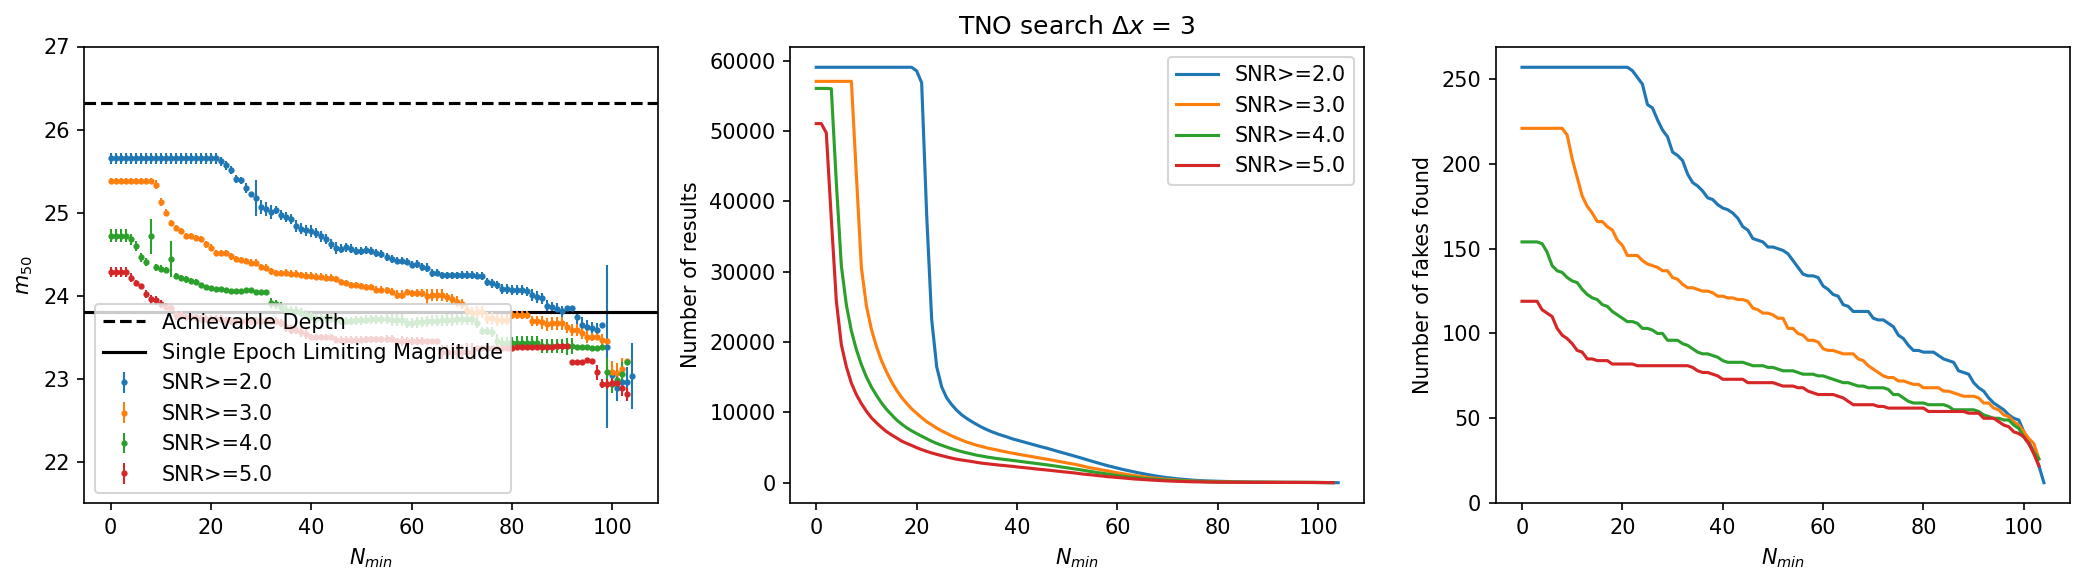

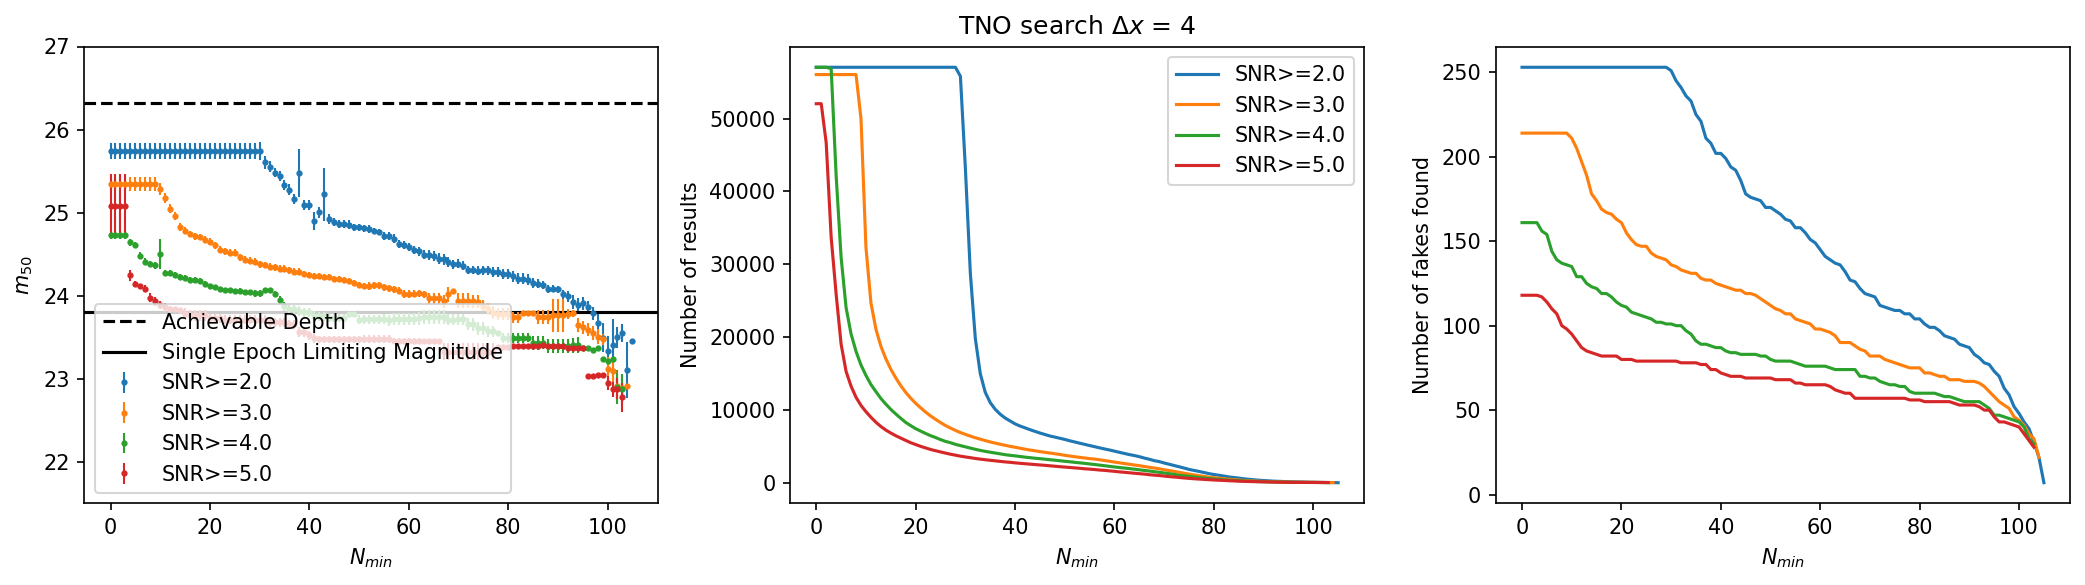

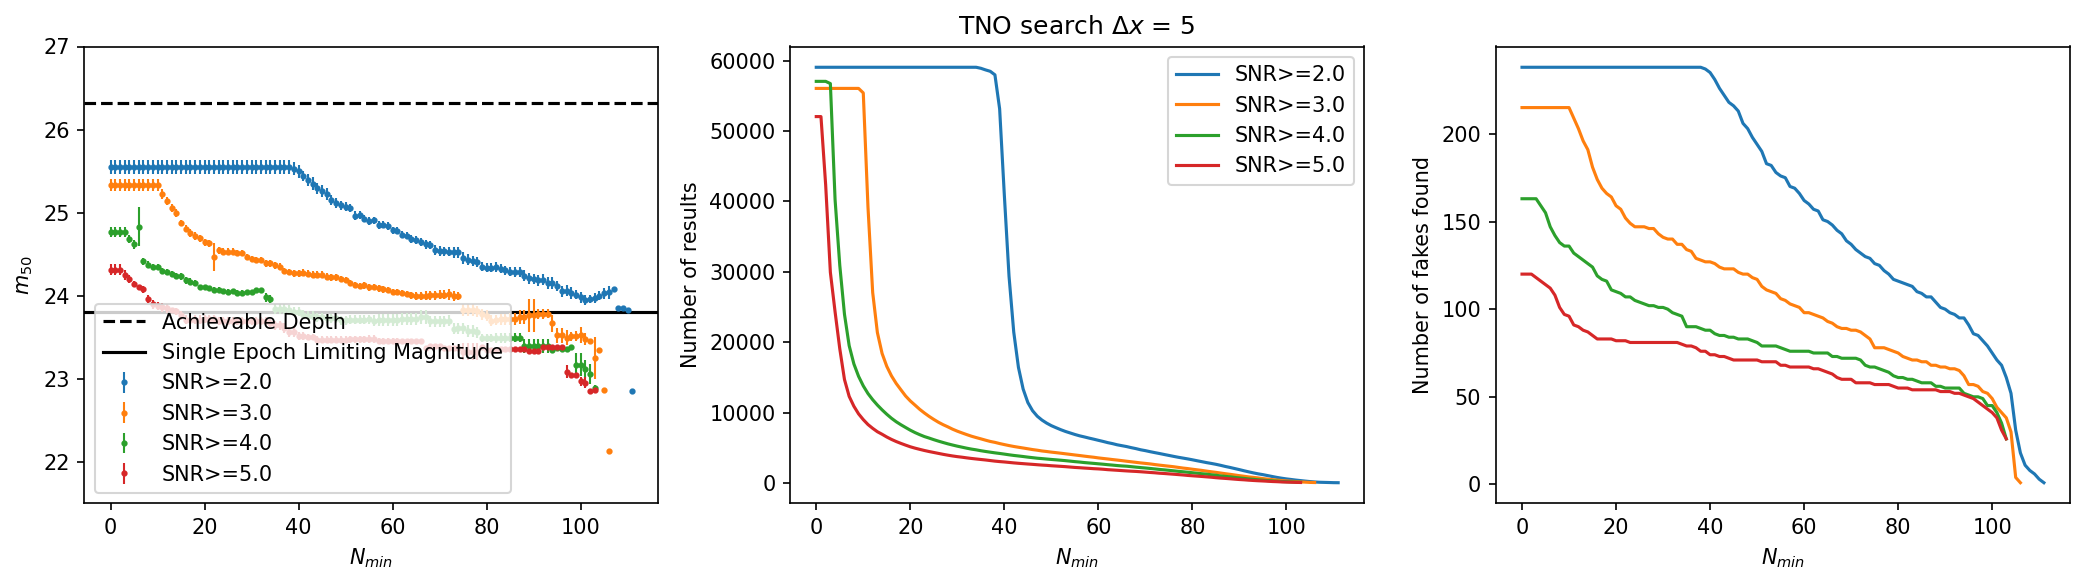

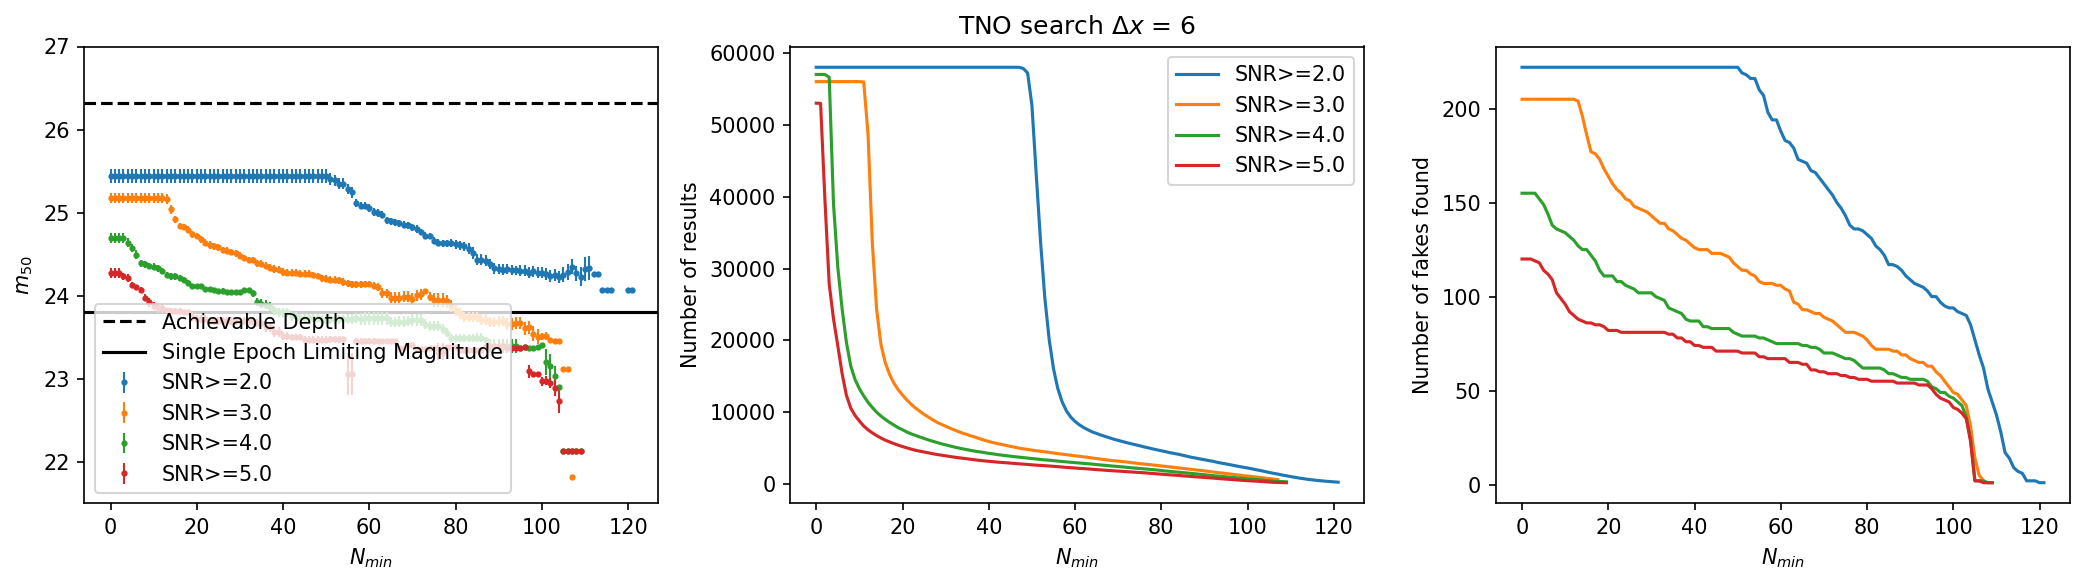

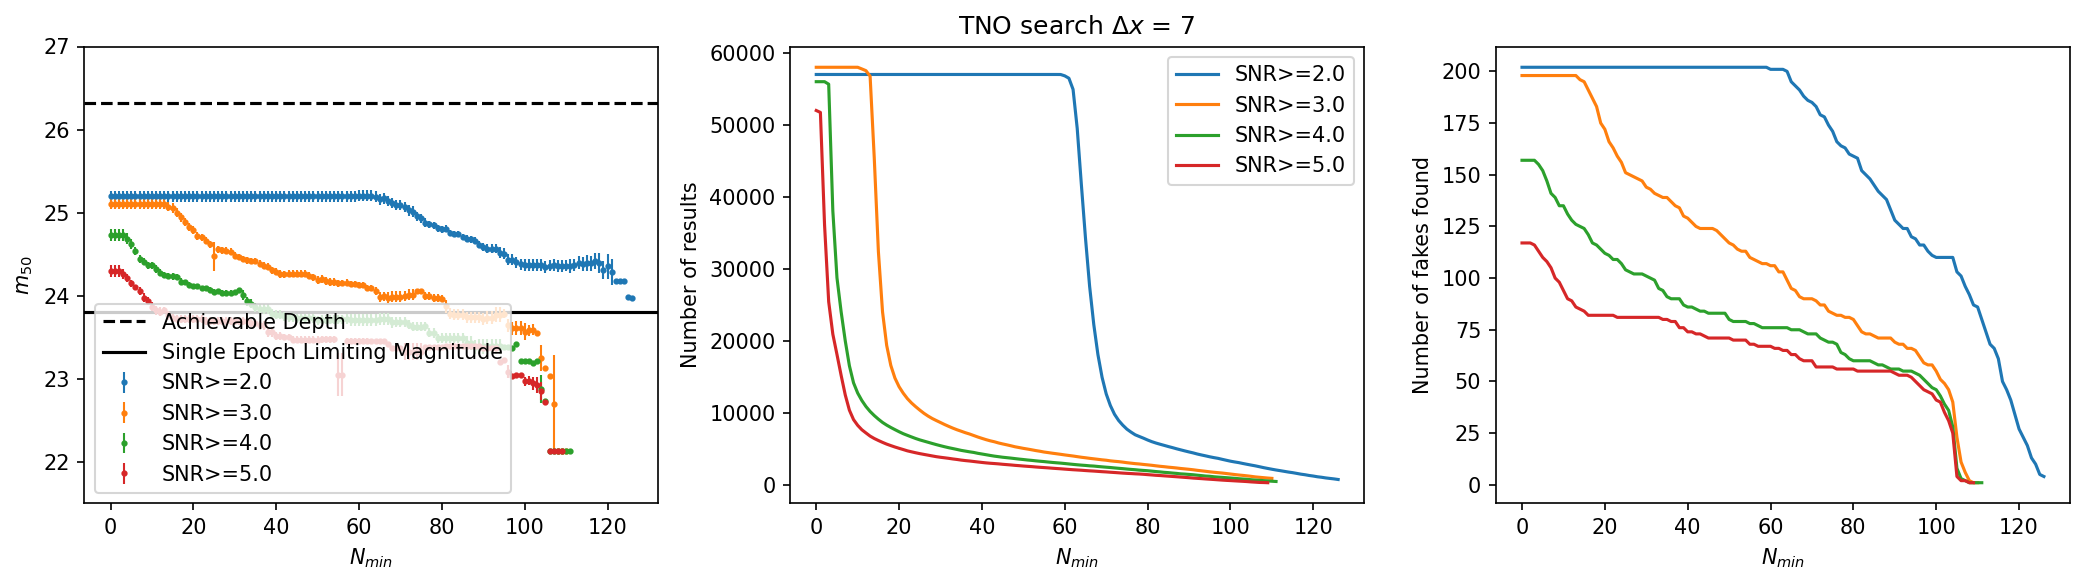

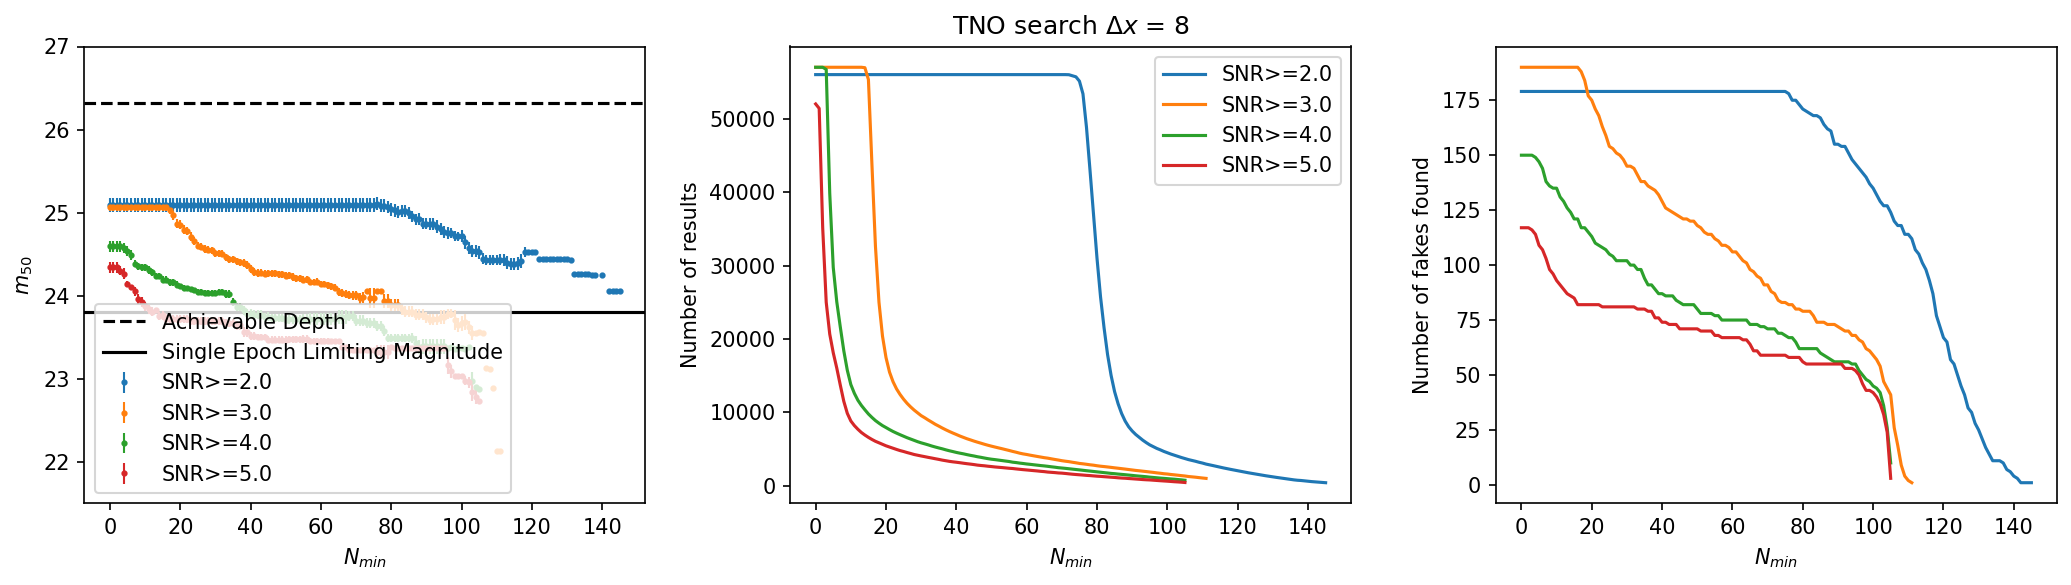

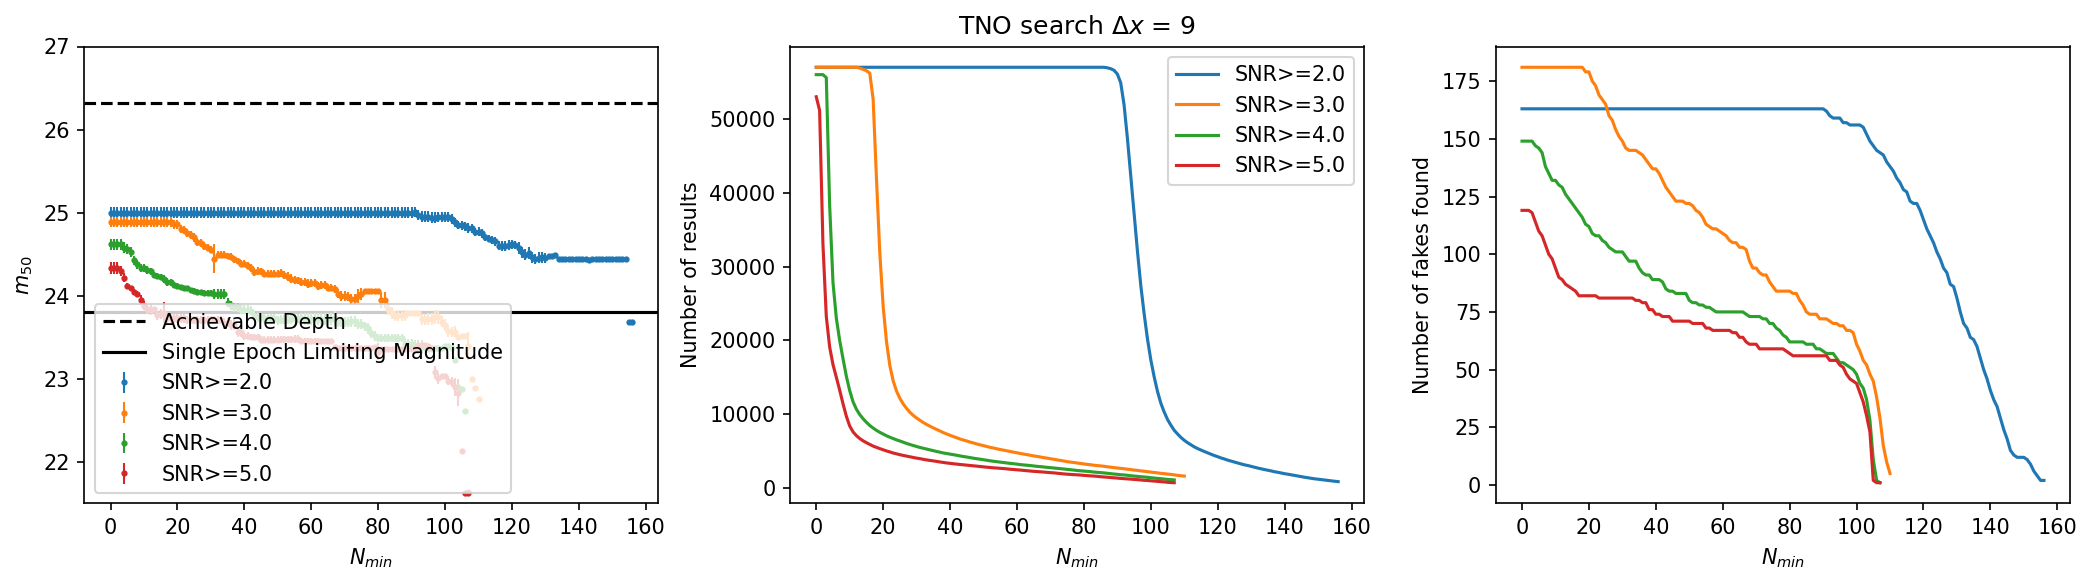

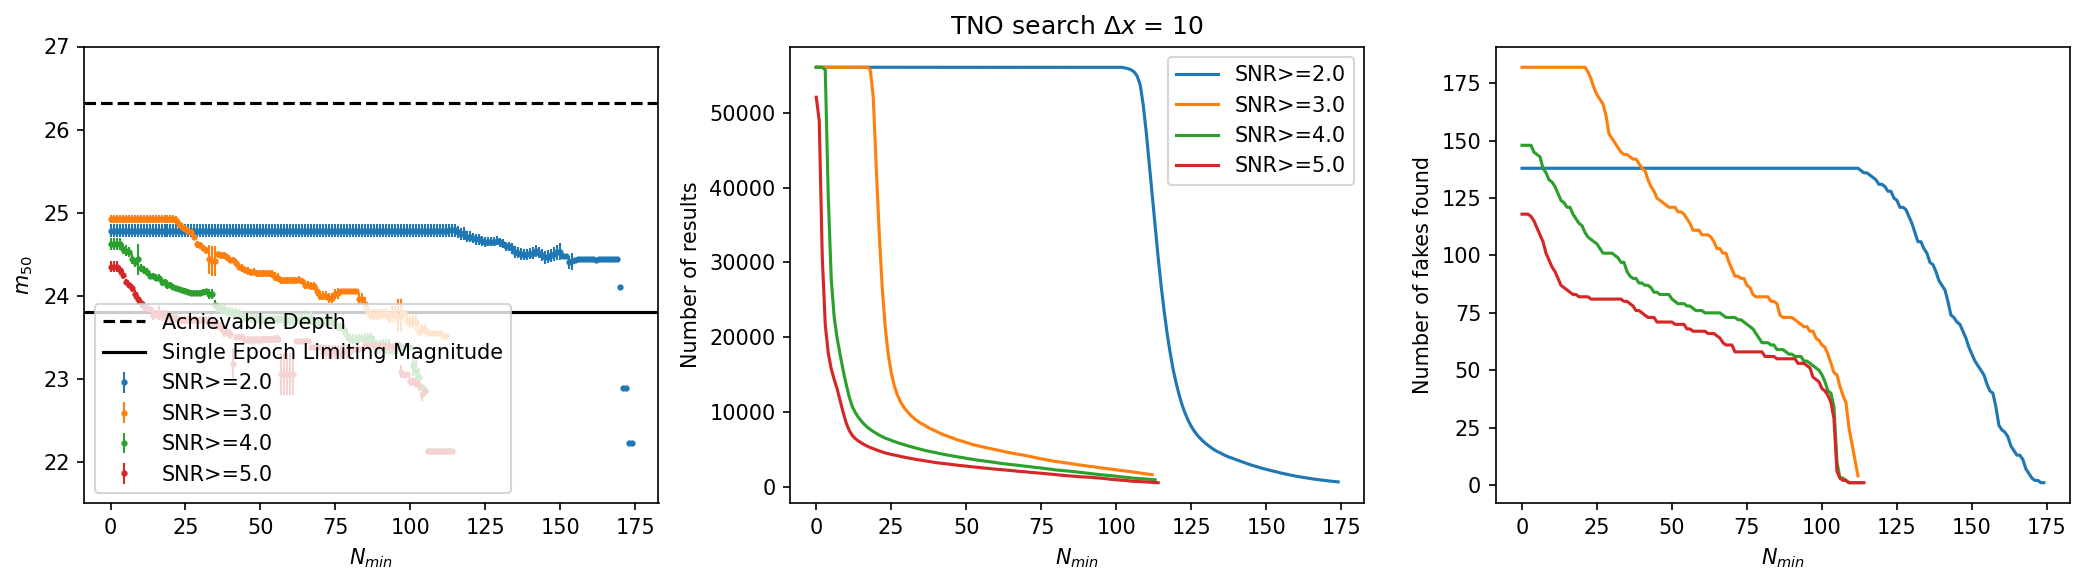

In [87]:
# images = read(Path("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_8/images.pkl"))

mag_ref = 23.8
expected = mag_ref + 5/2*np.log10(np.sqrt(104))

# fig = plt.figure(dpi=150, figsize=(14, 8))
# axs_2d = fig.subplots(2, 3, sharex=True)
    
for i, t in enumerate(roc_lookup['tno']):
    fig = plt.figure(dpi=150, figsize=(14, 4))
    axs_2d = np.atleast_2d(fig.subplots(1, 3, sharex=True))
    i = 0
    if i > 1:
        break
    for j, snr in enumerate(roc_lookup['tno'][t]):
        axs = axs_2d[i]
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][t][snr]
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        m = m_50_err > 1
        m_50_err[m] = np.nan
        plt.sca(axs[0])
        plt.errorbar(x, m_50, yerr=m_50_err, fmt='o', lw=1, ms=2, label=f"SNR>={snr}")
#         plt.scatter(x, m_50, s=4)
    #     plt.yscale("log")
    #     plt.colorbar()

        plt.sca(axs[1])
        plt.plot(x, n_results, label=f"SNR>={snr}")
        plt.sca(axs[2])
        plt.plot(x, n_fakes_found)
    #     plt.colorbar()
        plt.sca(axs[0])
        plt.xlabel("$N_{min}$")
        plt.ylabel("$m_{50}$")

        if j == 0:
#             plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
#             plt.axhline(mag_ref, color='k', ls=':', label="Single Epoch Limiting Magnitude")
#             plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
            plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
            plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")

        plt.ylim(21.5, 27)
        plt.legend(loc='lower left')
        plt.sca(axs[1])
        plt.xlabel("$N_{min}$")
        plt.ylabel("Number of results")
        plt.title({"tno": "TNO", "ast": "MBA"}.get("tno") + " search " + "$\Delta x$ = " + f"{t}")
        plt.legend()

        plt.sca(axs[2])
        plt.xlabel("$N_{min}$")
        plt.ylabel("Number of fakes found")

    fig.tight_layout()
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.pdf")
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.png")
    plt.show()

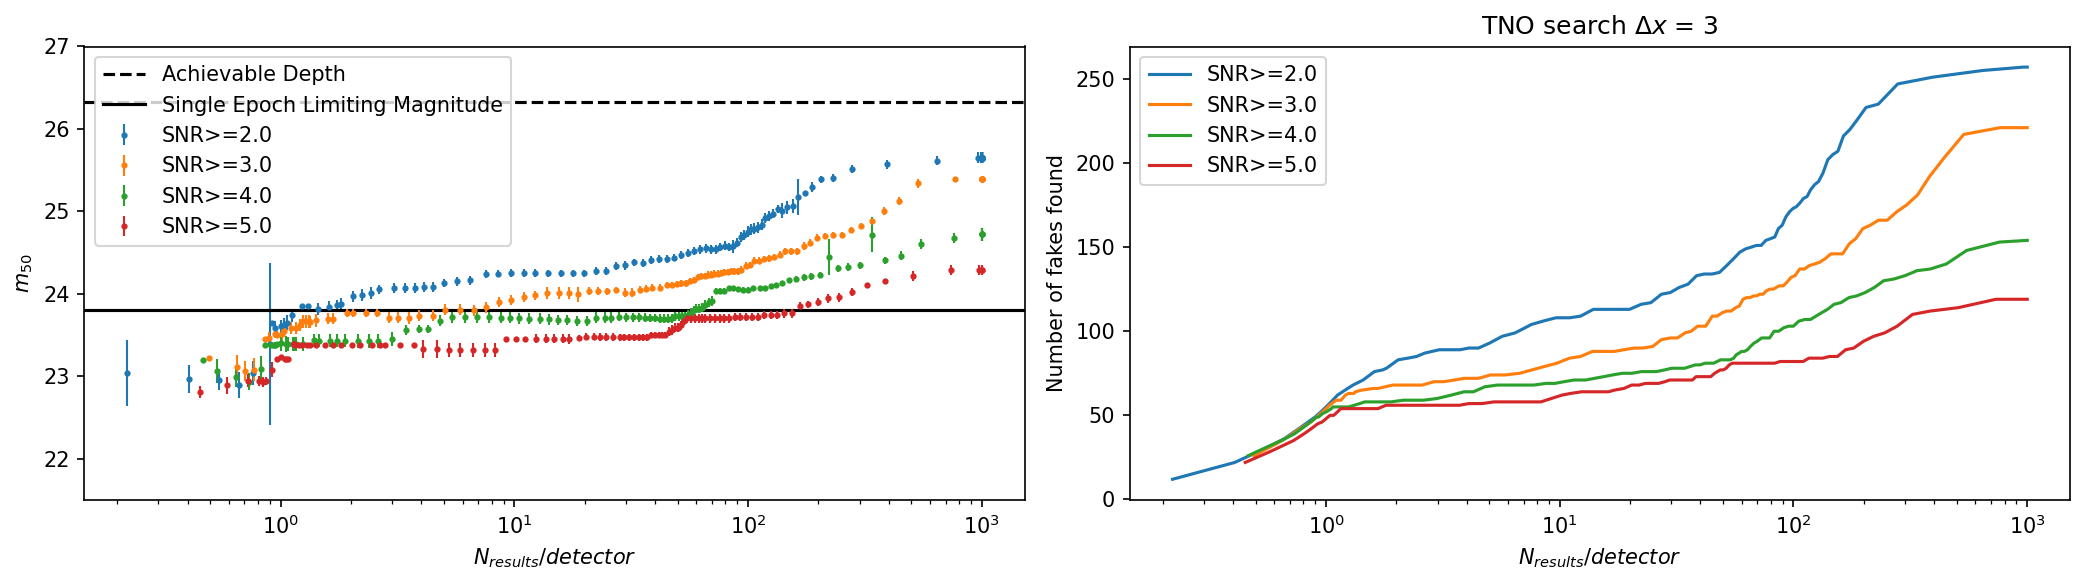

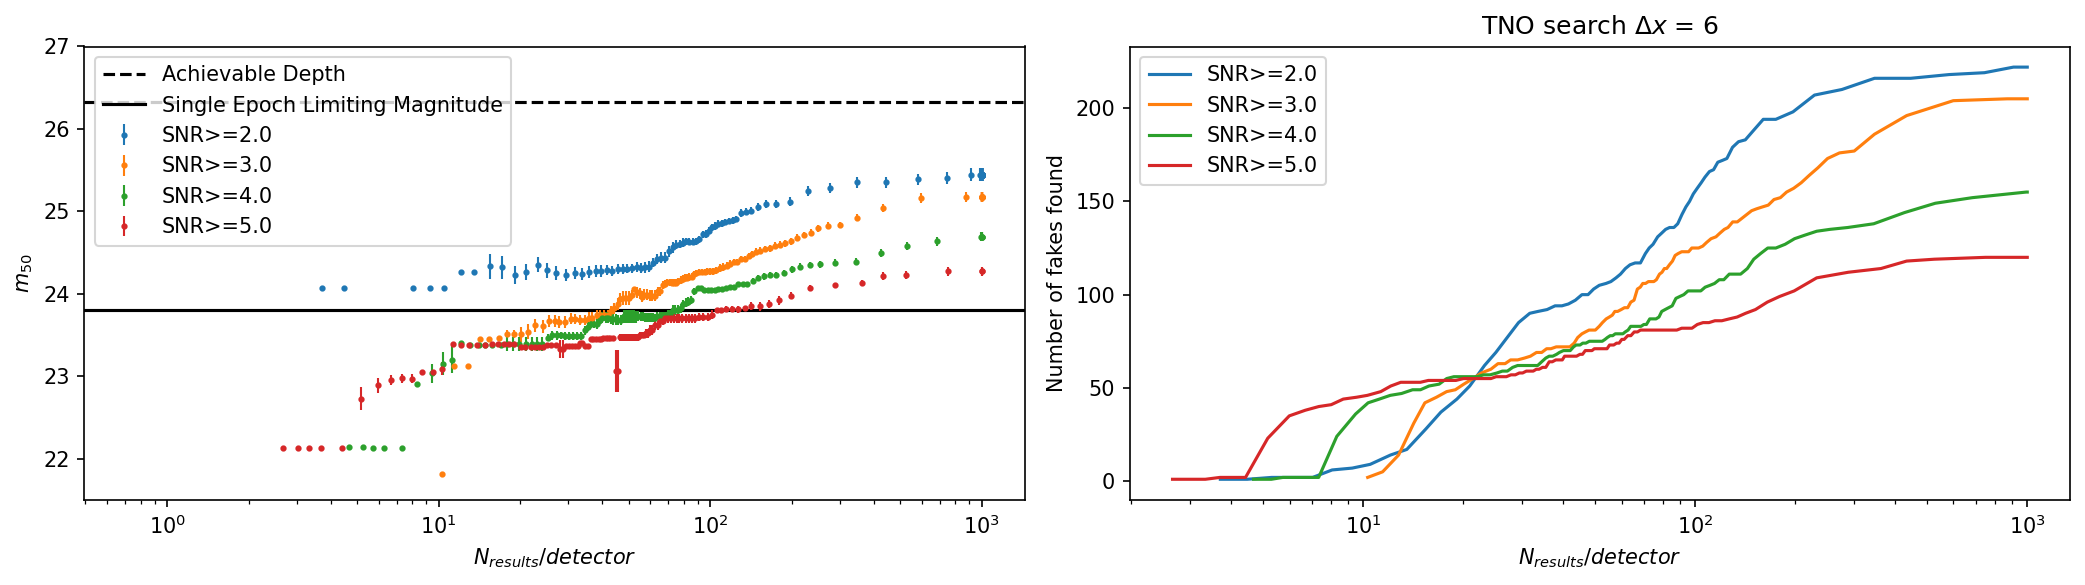

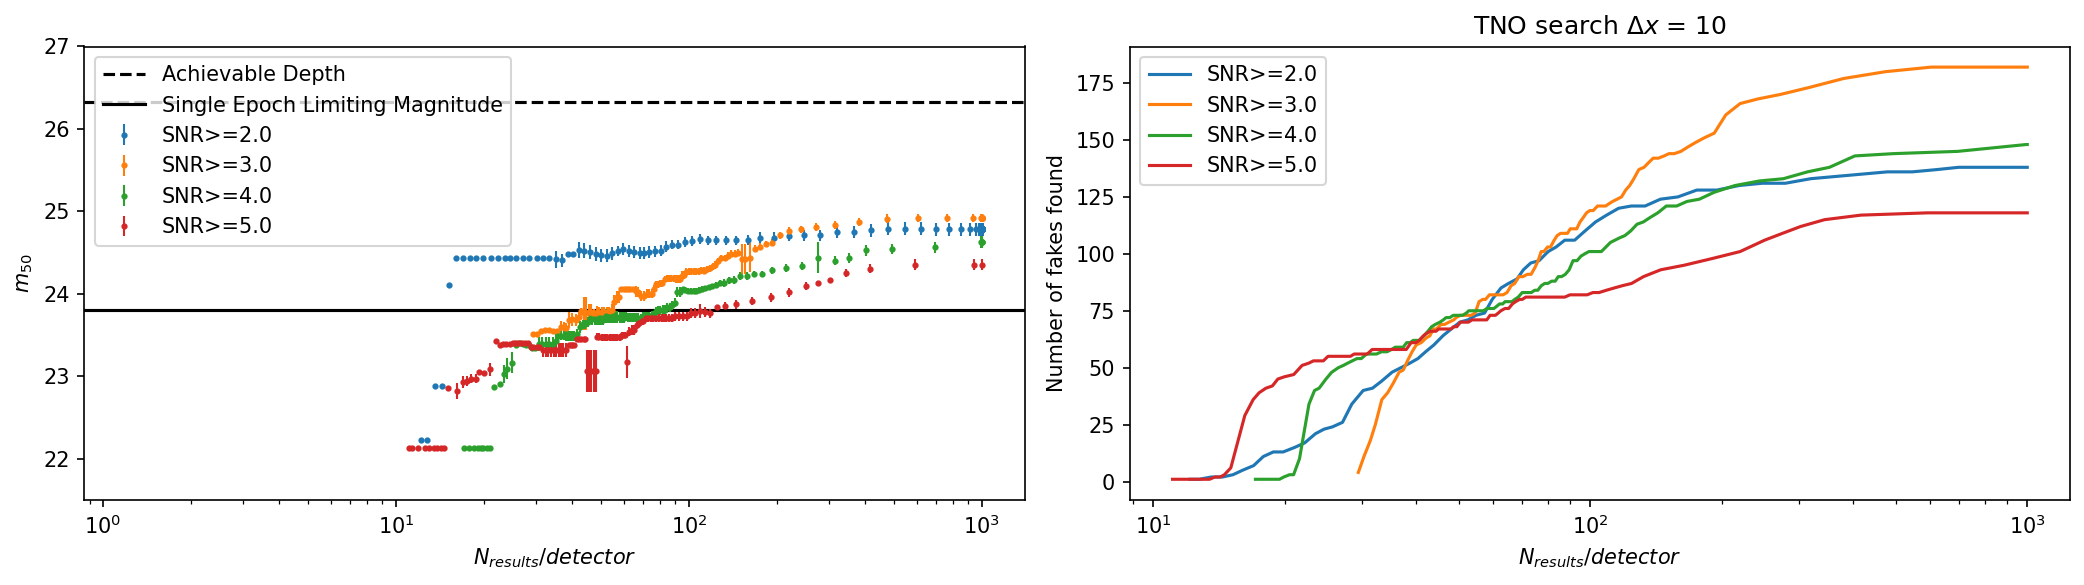

In [94]:
# images = read(Path("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_8/images.pkl"))

mag_ref = 23.8
expected = mag_ref + 5/2*np.log10(np.sqrt(104))

# fig = plt.figure(dpi=150, figsize=(14, 8))
# axs_2d = fig.subplots(2, 3, sharex=True)
    
for i, t in enumerate([3, 6, 10]):
    fig = plt.figure(dpi=150, figsize=(14, 4))
    axs_2d = np.atleast_2d(fig.subplots(1, 2, sharex=False))
    i = 0
    if i > 1:
        break
    for j, snr in enumerate(roc_lookup['tno'][t]):
        axs = axs_2d[i]
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][t][snr]
        
        _j = joined['tno'][t]
        _j = _j[_j['snr'] == snr]
        n_detectors = len(set(_j['detector']))
        
#         N_results = int(n) * n_detectors
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        m = m_50_err > 1
        m_50_err[m] = np.nan
        plt.sca(axs[0])
        plt.errorbar(n_results / n_detectors, m_50, yerr=m_50_err, fmt='o', lw=1, ms=2, label=f"SNR>={snr}")
#         plt.scatter(x, m_50, s=4)
    #     plt.yscale("log")
    #     plt.colorbar()

        plt.sca(axs[1])
        plt.plot(n_results / n_detectors, n_fakes_found, label=f"SNR>={snr}")
#         plt.sca(axs[2])
#         plt.plot(x, n_fakes_found)
    #     plt.colorbar()
        plt.sca(axs[0])
        plt.xlabel("$N_{results} / detector$")
        plt.ylabel("$m_{50}$")
        plt.xscale("log")

        if j == 0:
#             plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
#             plt.axhline(mag_ref, color='k', ls=':', label="Single Epoch Limiting Magnitude")
#             plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
            plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
            plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")

        plt.ylim(21.5, 27)
        plt.legend(loc='upper left')
        plt.sca(axs[1])
        plt.xlabel("$N_{results} / detector$")
        plt.xscale("log")
        plt.ylabel("Number of fakes found")
        plt.title({"tno": "TNO", "ast": "MBA"}.get("tno") + " search " + "$\Delta x$ = " + f"{t}")
        plt.legend()

#         plt.sca(axs[2])
#         plt.xlabel("$N_{min}$")
#         plt.ylabel("Number of fakes found")

    fig.tight_layout()
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.pdf")
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.png")
    plt.show()

In [13]:
roc_lookup['tno'].keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10])

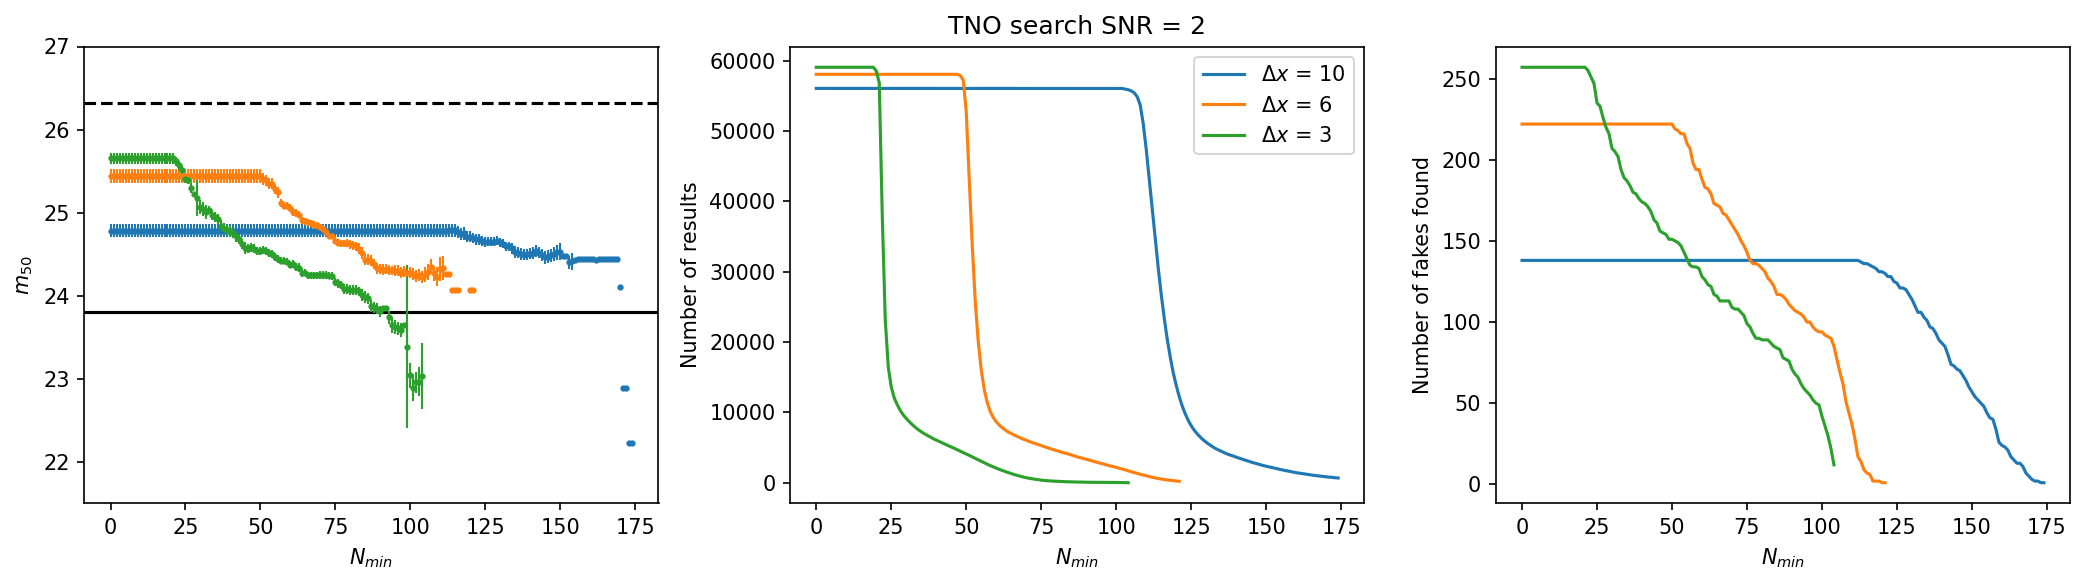

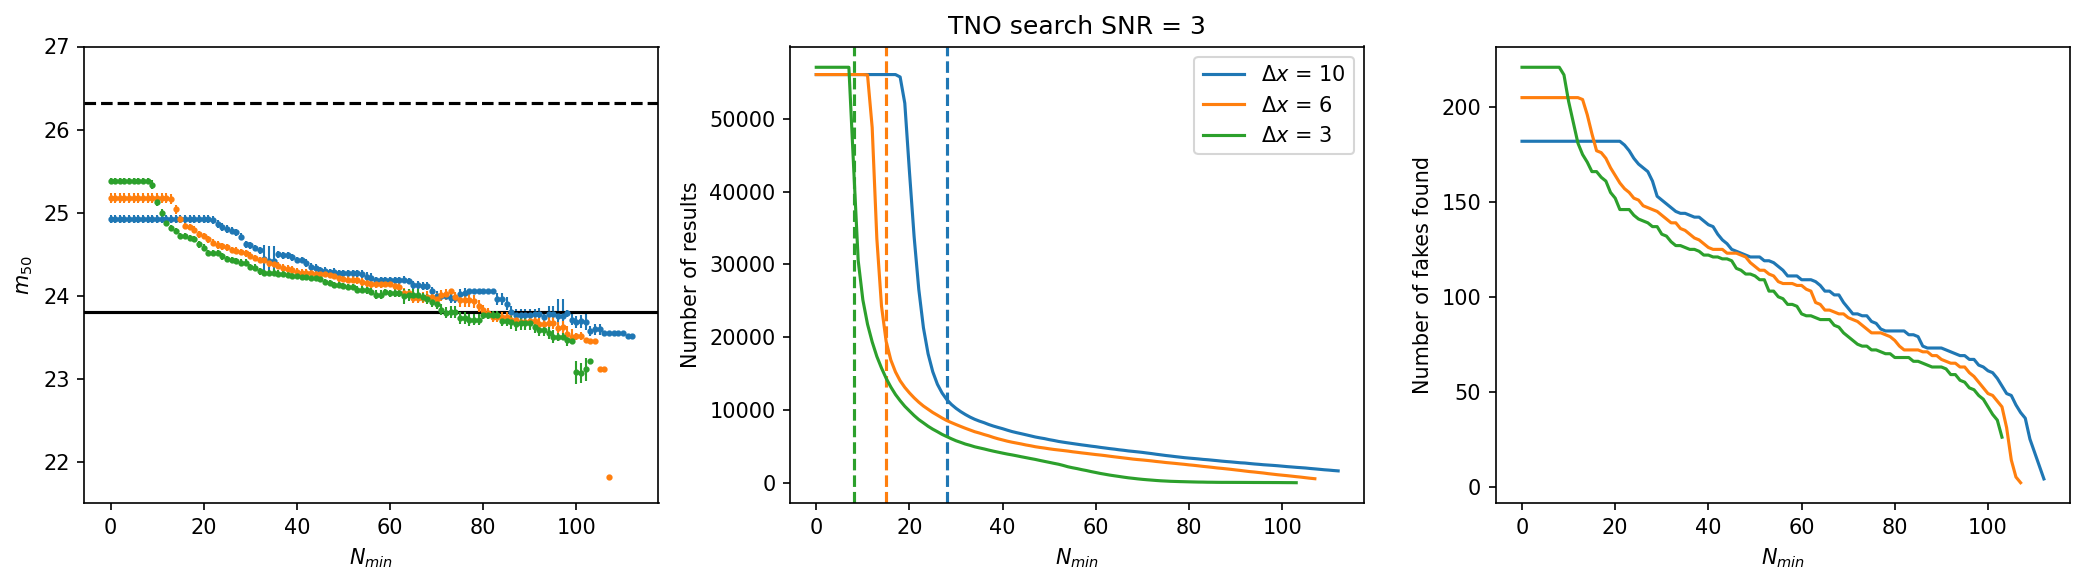

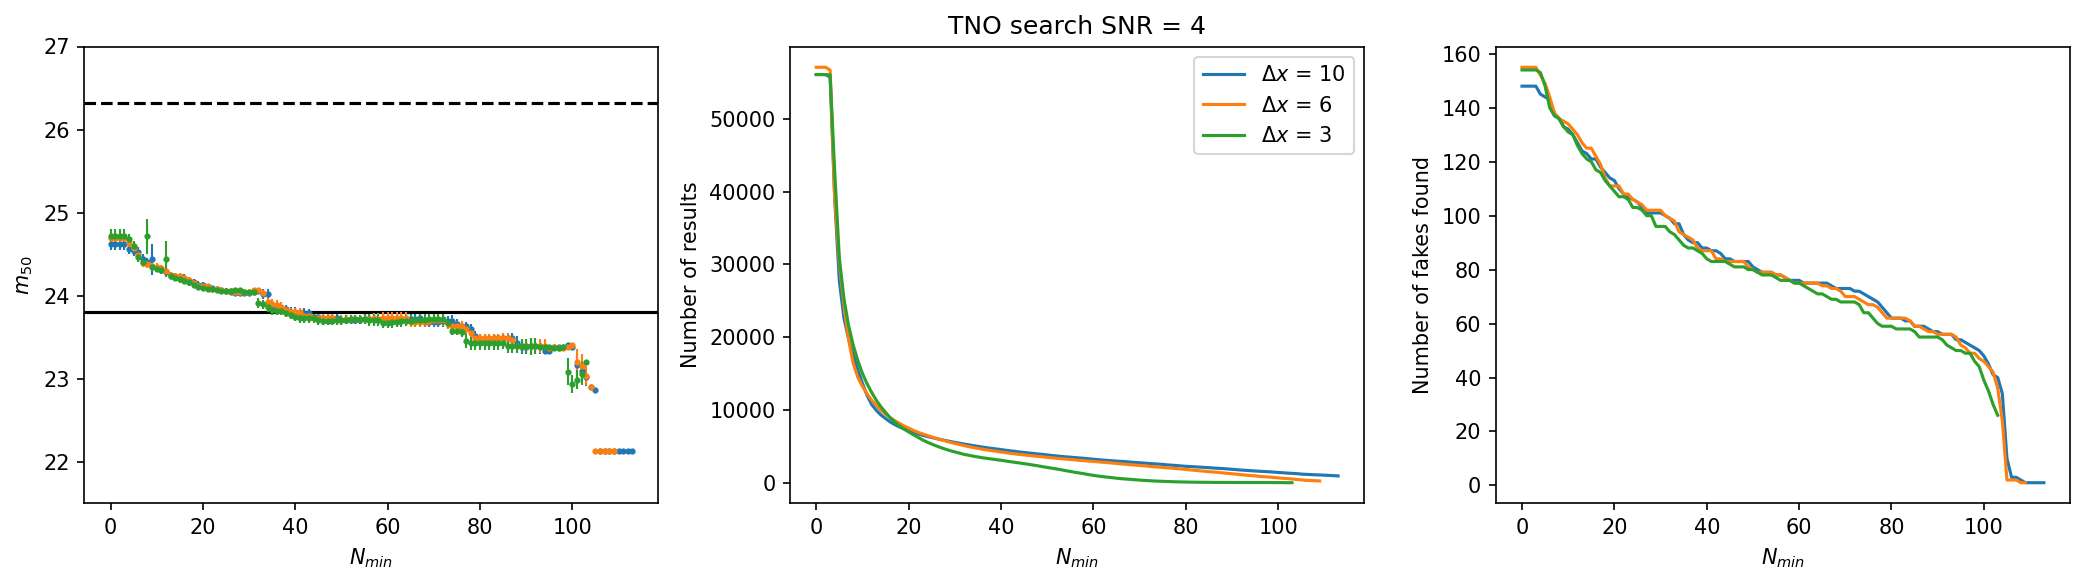

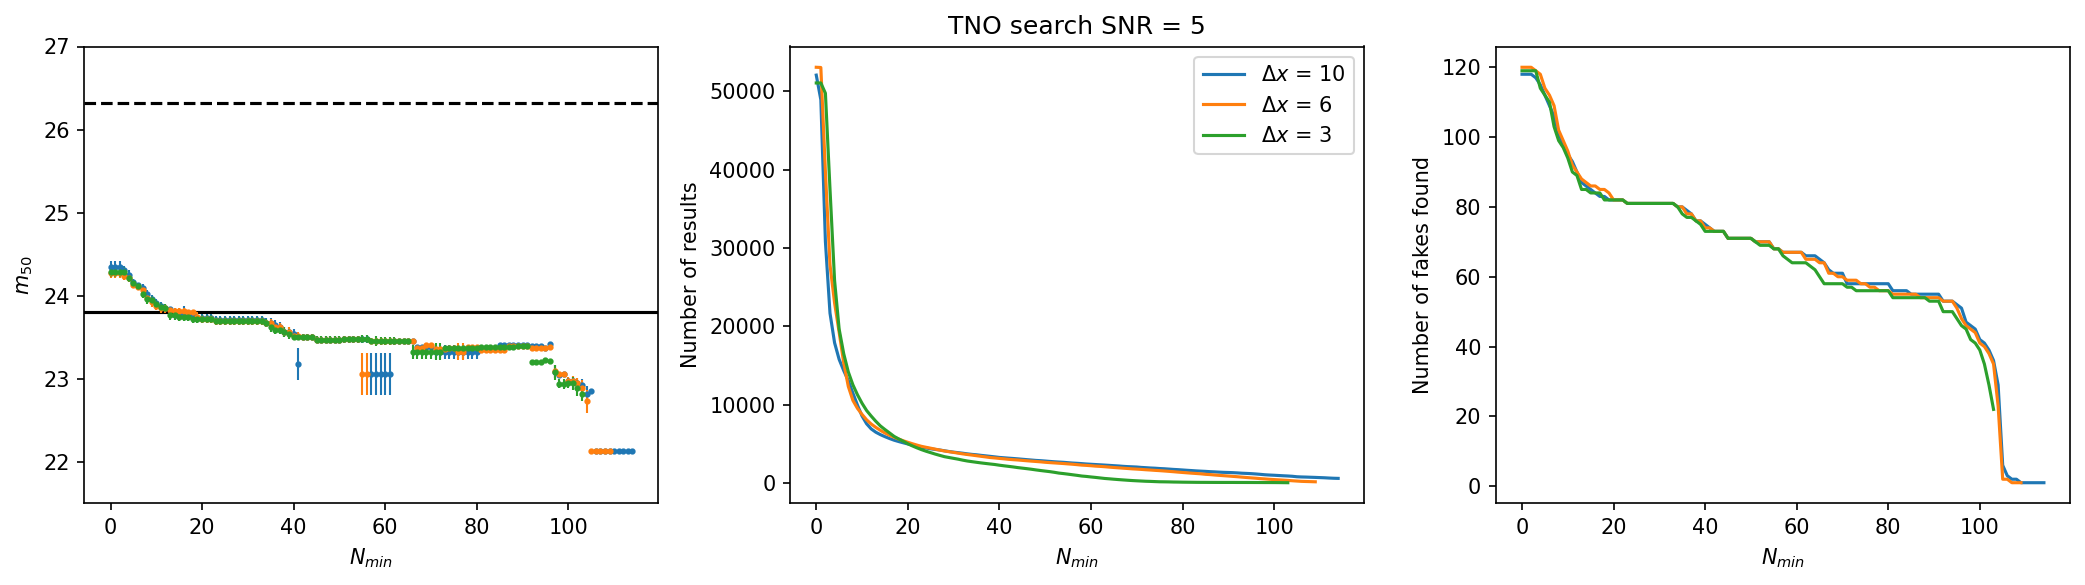

In [92]:
# images = read(Path("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_8/images.pkl"))

mag_ref = 23.8
expected = mag_ref + 5/2*np.log10(np.sqrt(104))

# fig = plt.figure(dpi=150, figsize=(14, 8))
# axs_2d = fig.subplots(2, 3, sharex=True)
    

n_min_lookup = {
    3: {
        10: 28,
        6: 15,
        3: 8,
    }
}
    
for j, snr in enumerate([2, 3, 4, 5]):    
    fig = plt.figure(dpi=150, figsize=(14, 4))
    axs_2d = np.atleast_2d(fig.subplots(1, 3, sharex=True))
#     i = 0
#     if i > 1:
#         break
#     for i, t in sorted(enumerate(roc_lookup['tno']), reverse=True):
    for i, t in enumerate([10, 6, 3]):
        axs = axs_2d[0]
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][t][snr]
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        m = m_50_err > 1
        m_50_err[m] = np.nan
        plt.sca(axs[0])
        plt.errorbar(x, m_50, yerr=m_50_err, fmt='o', lw=1, ms=2)#, label=f"$\Delta x$={t}")
#         plt.scatter(x, m_50, s=4)
    #     plt.yscale("log")
    #     plt.colorbar()

        plt.sca(axs[1])
        plt.plot(x, n_results, label=f"$\Delta x$ = {t}")
        plt.sca(axs[2])
        plt.plot(x, n_fakes_found)
    #     plt.colorbar()
        plt.sca(axs[0])
        plt.xlabel("$N_{min}$")
        plt.ylabel("$m_{50}$")

        if i == 0:
#             plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
#             plt.axhline(mag_ref, color='k', ls=':', label="Single Epoch Limiting Magnitude")
#             plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
            plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
            plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")

        plt.ylim(21.5, 27)
#         plt.legend(loc='lower left')
        plt.sca(axs[1])
        plt.xlabel("$N_{min}$")
        plt.ylabel("Number of results")
        plt.title({"tno": "TNO", "ast": "MBA"}.get("tno") + " search " + "SNR = " + f"{snr}")
        plt.legend()
        if snr in n_min_lookup:
            if t in n_min_lookup[snr]:
                plt.axvline(n_min_lookup[snr][t], color=f"C{i}", ls="--")

        plt.sca(axs[2])
        plt.xlabel("$N_{min}$")
        plt.ylabel("Number of fakes found")

    fig.tight_layout()
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.pdf")
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.png")
    plt.show()

In [64]:
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103])

In [124]:
sum(list(map(lambda x : len(fakes_lookup[x].group_by("ORBITID").groups), fakes_lookup)))

909

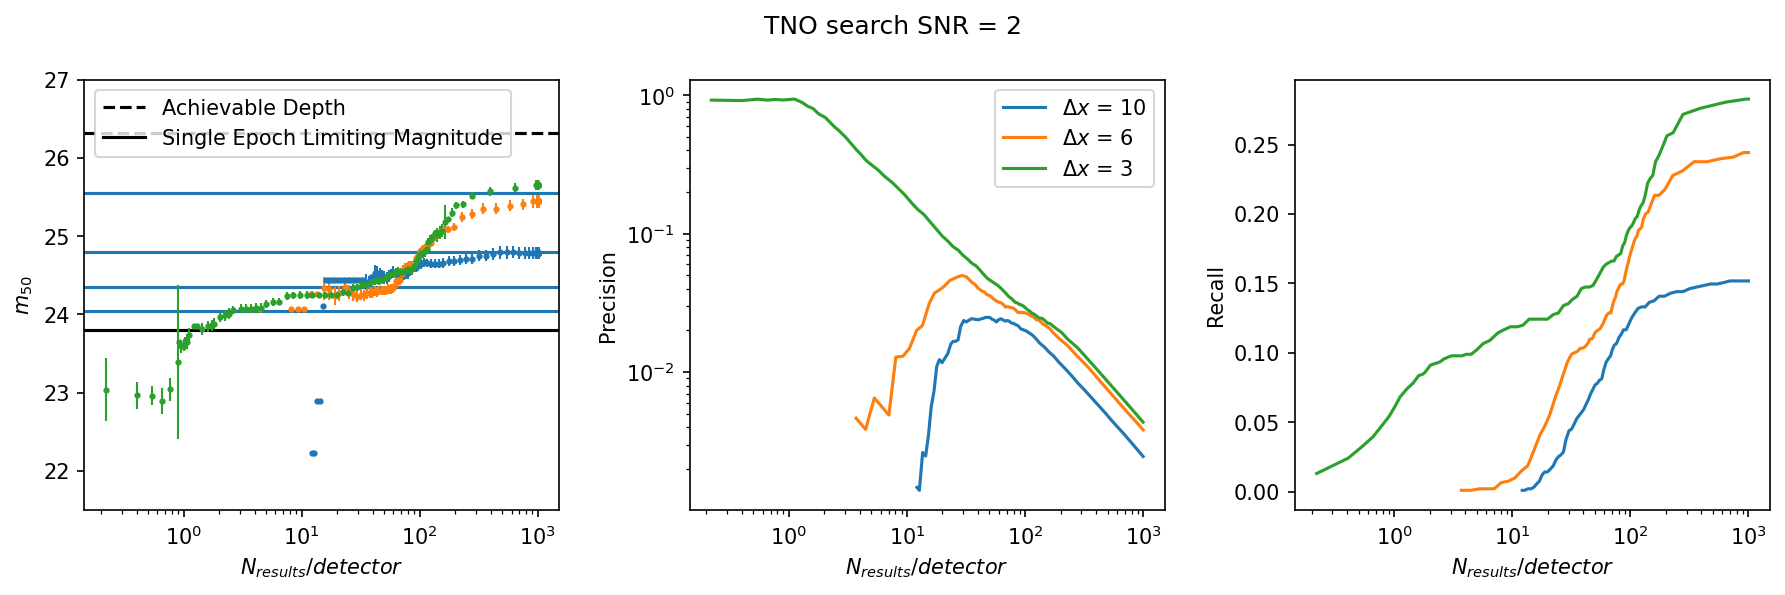

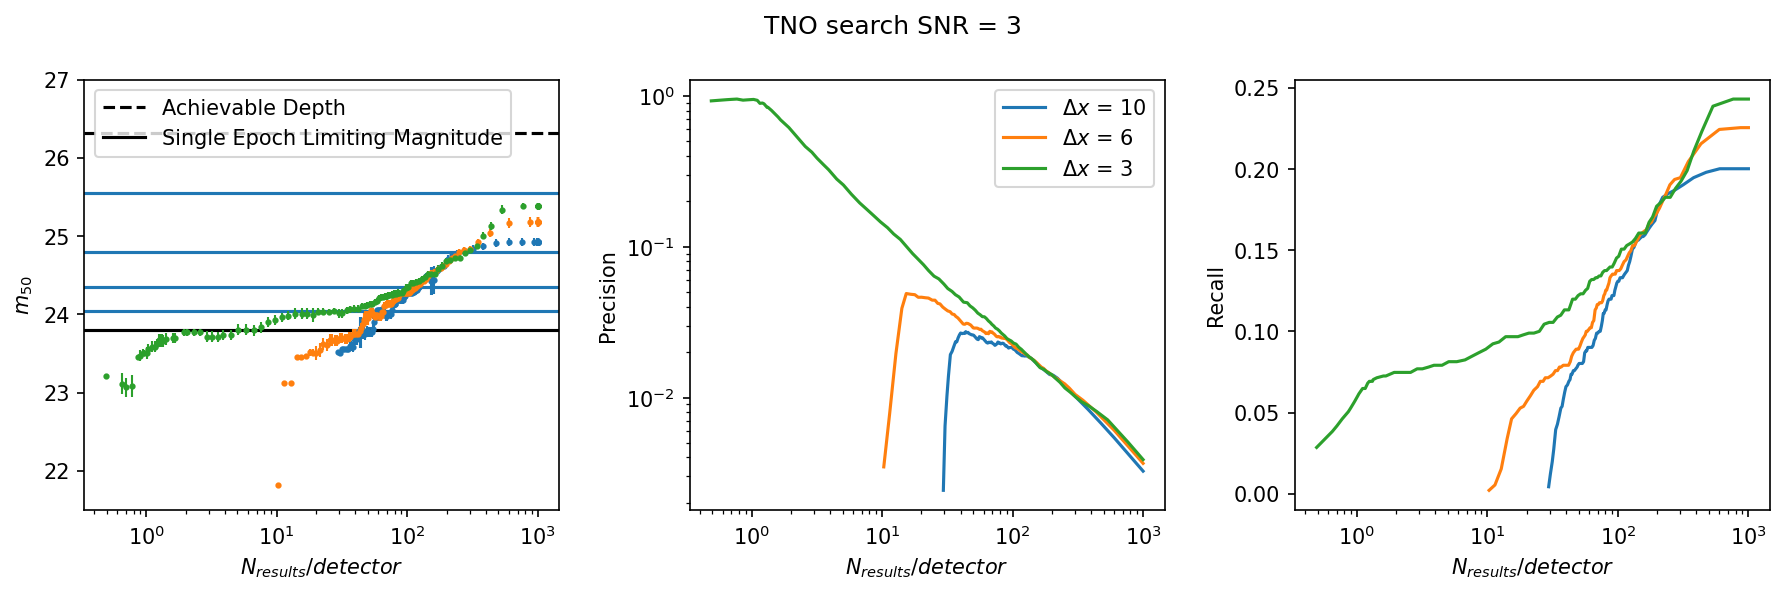

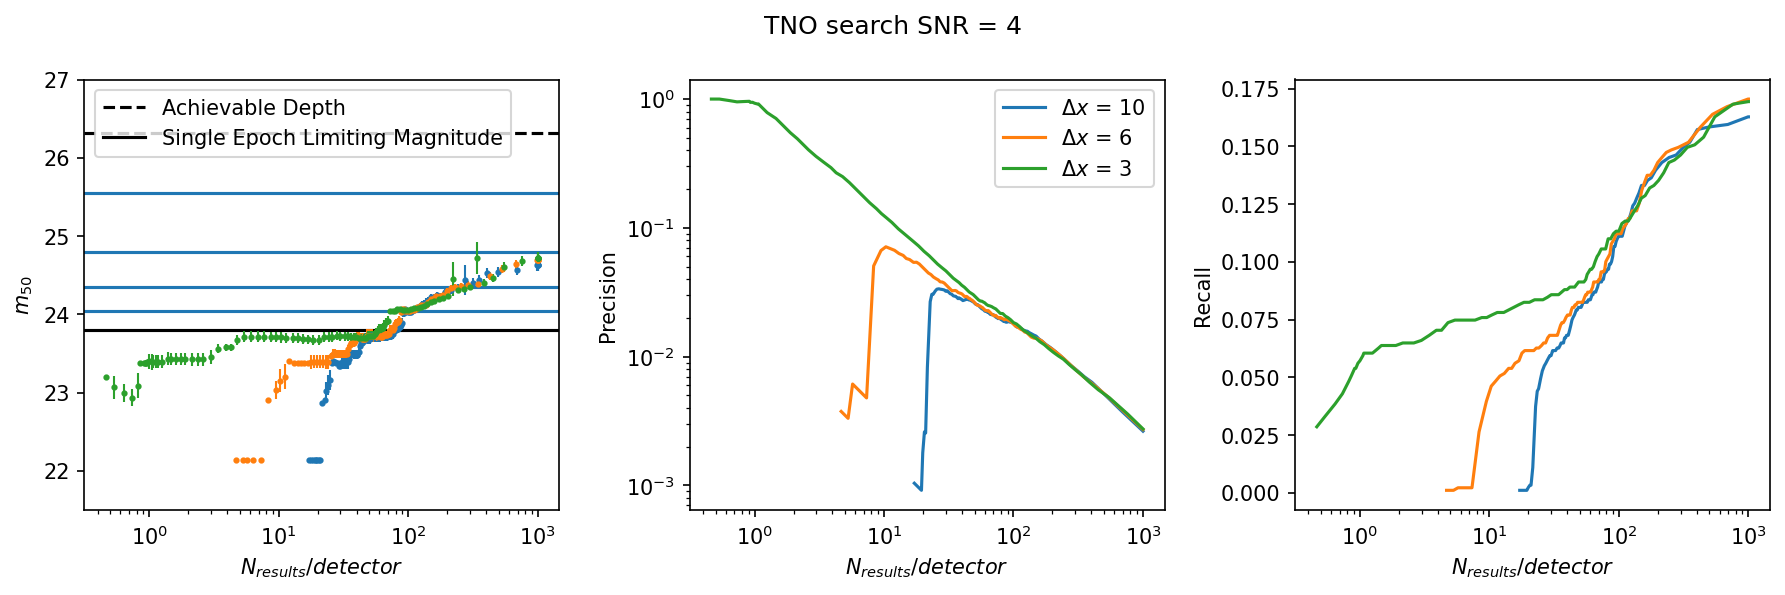

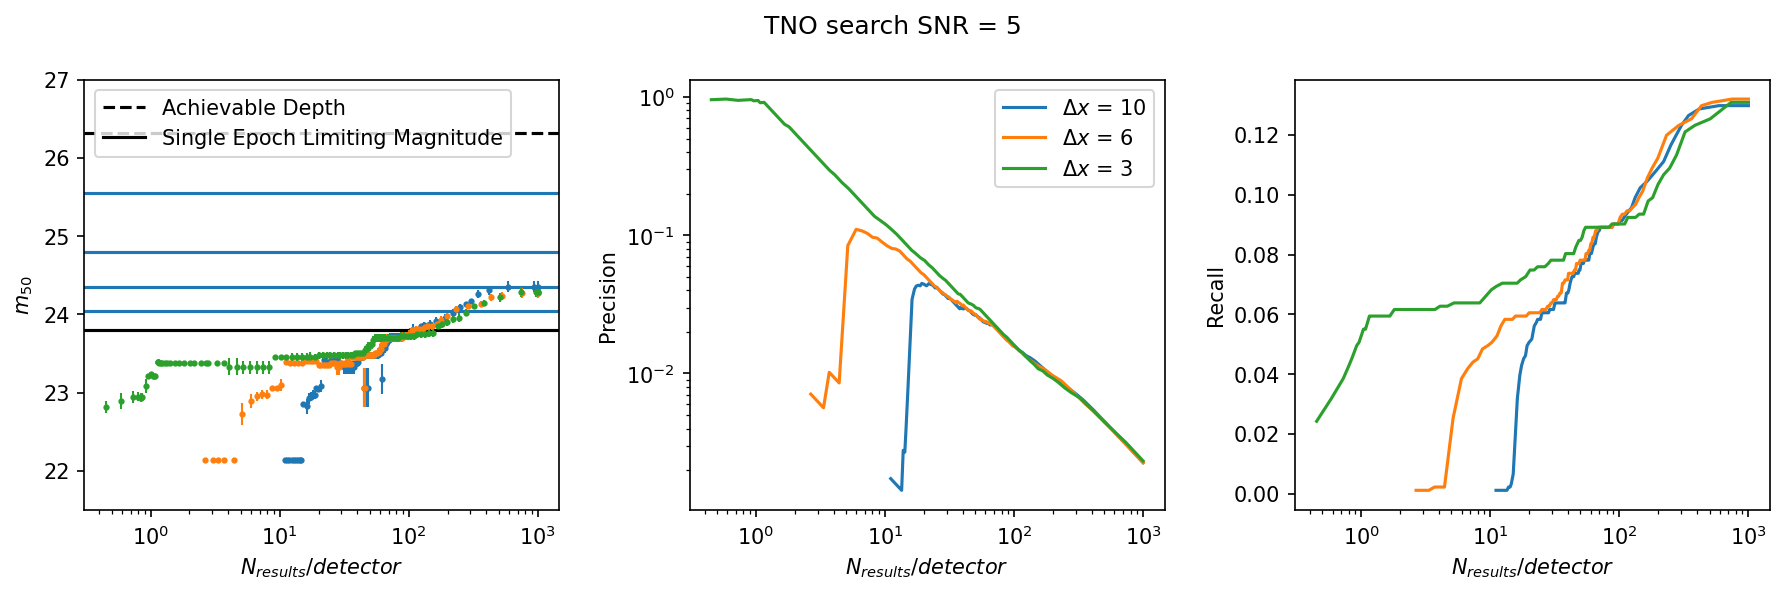

In [125]:
# images = read(Path("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_8/images.pkl"))

mag_ref = 23.8
expected = mag_ref + 5/2*np.log10(np.sqrt(104))

# fig = plt.figure(dpi=150, figsize=(14, 8))
# axs_2d = fig.subplots(2, 3, sharex=True)
    

n_min_lookup = {
    3: {
        10: 28,
        6: 15,
        3: 8,
    }
}

t = "tno"
    
for j, snr in enumerate([2, 3, 4, 5]):    
    fig = plt.figure(dpi=150, figsize=(12, 4))
    axs_2d = np.atleast_2d(fig.subplots(1, 3, sharex=True))
#     i = 0
#     if i > 1:
#         break
#     for i, t in sorted(enumerate(roc_lookup['tno']), reverse=True):
    for i, dx in enumerate([10, 6, 3]):
        axs = axs_2d[0]
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][dx][snr]
        
        precision = n_fakes_found/n_results
        recall = n_fakes_found/n_fakes        
        
        _j = joined[t][dx]
        _j = _j[_j['snr'] == snr]
        n_detectors = len(set(_j['detector']))
        
#         N_results = int(n) * n_detectors
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        m = m_50_err > 1
        m_50_err[m] = np.nan
        plt.sca(axs[0])
        plt.errorbar(n_results / n_detectors, m_50, yerr=m_50_err, fmt='o', lw=1, ms=2)#, label=f"$\Delta x$ = {dx}")
#         plt.scatter(x, m_50, s=4)
    #     plt.yscale("log")
    #     plt.colorbar()

        plt.sca(axs[1])
        plt.plot(n_results / n_detectors, precision, label=f"$\Delta x$ = {dx}")
        plt.sca(axs[2])
        plt.plot(n_results / n_detectors, n_fakes_found/909)
#         plt.colorbar()
        plt.sca(axs[0])
        plt.xlabel("$N_{results} / detector$")
        plt.ylabel("$m_{50}$")
        plt.xscale("log")

        if i == 0:
#             plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
#             plt.axhline(mag_ref, color='k', ls=':', label="Single Epoch Limiting Magnitude")
#             plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
            plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
            plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
        
            plt.axhline(mag_ref - 5/2*np.log10(1 / 5))
            plt.axhline(mag_ref - 5/2*np.log10(2 / 5))
            plt.axhline(mag_ref - 5/2*np.log10(3 / 5))
            plt.axhline(mag_ref - 5/2*np.log10(4 / 5))

        plt.ylim(21.5, 27)
        plt.legend(loc='upper left')
        plt.sca(axs[1])
        plt.xlabel("$N_{results} / detector$")
        plt.xscale("log")
        plt.yscale("log")
        plt.ylabel("Precision")
        plt.legend()
        plt.sca(axs[2])
        plt.xlabel("$N_{results} / detector$")
        plt.xscale("log")
        plt.ylabel("Recall")
        
    fig.suptitle({"tno": "TNO", "ast": "MBA"}.get("tno") + " search " + "SNR = " + f"{snr}")
    fig.tight_layout()
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.pdf")
    # plt.savefig(f"figures/m50_and_num_results_vs_Nmin.png")
    plt.show()

In [ ]:
# I want m50 at 200/detector and computational expense vs dx 
# m50 vs computational cost at 200/detector

In [29]:
roc_lookup[t][snr].keys()

dict_keys([3.0, 4.0, 5.0])

11400
11200
11200
11200
11600
11400
11400
11200


/tmp/ipykernel_20802/3986150930.py:29: RuntimeWarning: divide by zero encountered in log10
  __y = mag_ref - 5/2*np.log10(np.array(__x)/5)


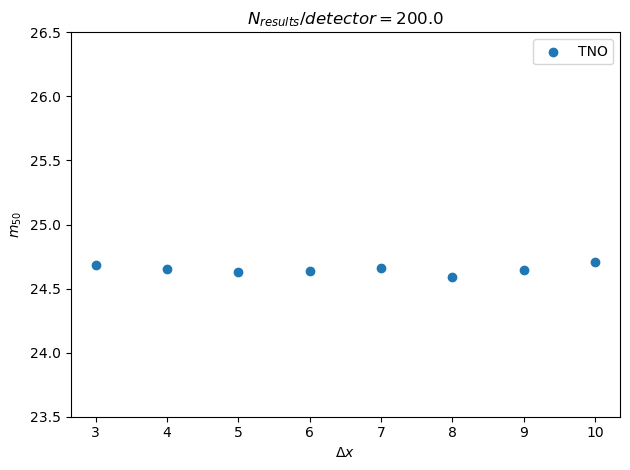

In [45]:
plt.figure()
_x = []
_y = []
_y_err = []
t = 'tno'

n = 2e2
for dx in range(3, 11):
    j = joined['tno'][dx]
    j = j[j['snr'] == 3.0]


    n_detectors = len(set(j['detector']))
    N_results = int(n) * n_detectors
    print(N_results)
    
    x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][dx][3.0]
    m_50 = np.array([f['m_50'] for f in fit_results])
    m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
    closest = np.argmin(np.abs(np.array(n_results) - N_results))
    fpr = n_fakes_found / N_results
    _x.append(dx)
    _y.append(m_50[closest])
    _y_err.append(m_50_err[closest])

#         plt.errorbar(_x, _y, yerr=_y_err, fmt='o', label={"tno": "TNO", "ast": "MBA"}.get(t))
plt.scatter(_x, _y, label={"tno": "TNO", "ast": "MBA"}.get(t))
__x = np.linspace(0, 5, 100)
__y = mag_ref - 5/2*np.log10(np.array(__x)/5)
# plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
# plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
# plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
# plt.scatter(_x, _y)
plt.ylim(23.5, 26.5)
plt.legend()
#     plt.xticks([1, 2, 3, 4, 5])
plt.xlabel("$\Delta x$")
plt.ylabel("$m_{50}$")
plt.title("$N_{results}/detector = $" + str(N_results/n_detectors))
plt.legend()
plt.tight_layout()
#     plt.savefig(f"figures/m50_Nresults_{n}.pdf")
#     plt.savefig(f"figures/m50_Nresults_{n}.png")
plt.show()

In [ ]:
plt.figure()
_x = []
_y = []
_y_err = []
t = 'tno'

n = 2e2
for dx in range(3, 11):
    j = joined['tno'][dx]
    j = j[j['snr'] == 3.0]


    n_detectors = len(set(j['detector']))
    N_results = int(n) * n_detectors
    print(N_results)
    
    x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][dx][3.0]
    m_50 = np.array([f['m_50'] for f in fit_results])
    m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
    closest = np.argmin(np.abs(np.array(n_results) - N_results))
    fpr = n_fakes_found / N_results
    _x.append(dx)
    _y.append(m_50[closest])
    _y_err.append(m_50_err[closest])

#         plt.errorbar(_x, _y, yerr=_y_err, fmt='o', label={"tno": "TNO", "ast": "MBA"}.get(t))
plt.scatter(_x, _y, label={"tno": "TNO", "ast": "MBA"}.get(t))
__x = np.linspace(0, 5, 100)
__y = mag_ref - 5/2*np.log10(np.array(__x)/5)
# plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
# plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
# plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
# plt.scatter(_x, _y)
plt.ylim(23.5, 26.5)
plt.legend()
#     plt.xticks([1, 2, 3, 4, 5])
plt.xlabel("$\Delta x$")
plt.ylabel("$m_{50}$")
plt.title("$N_{results}/detector = $" + str(N_results/n_detectors))
plt.legend()
plt.tight_layout()
#     plt.savefig(f"figures/m50_Nresults_{n}.pdf")
#     plt.savefig(f"figures/m50_Nresults_{n}.png")
plt.show()

/tmp/ipykernel_20802/106843616.py:33: RuntimeWarning: divide by zero encountered in log10
  __y = mag_ref - 5/2*np.log10(np.array(__x)/5)


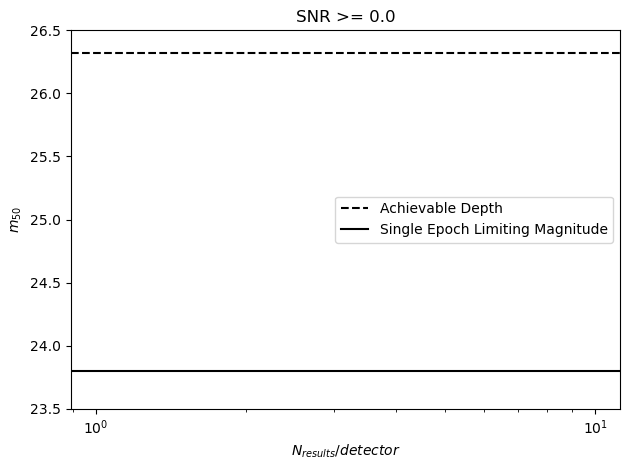

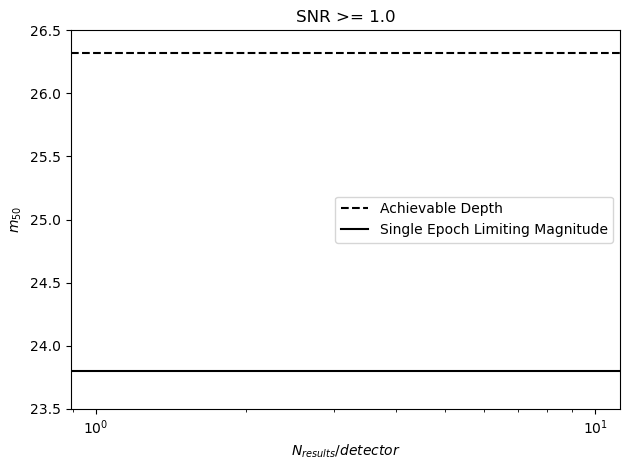

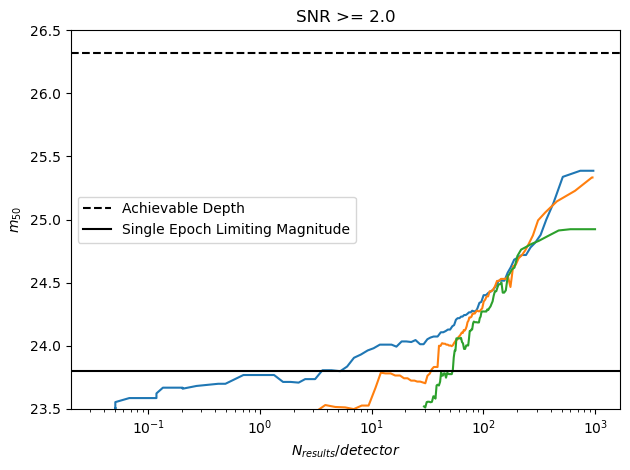

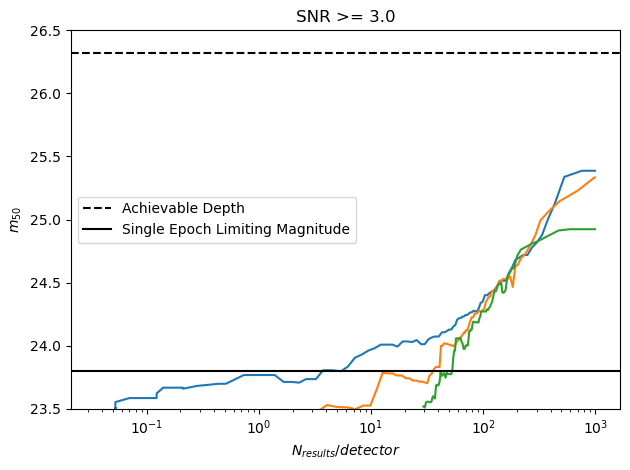

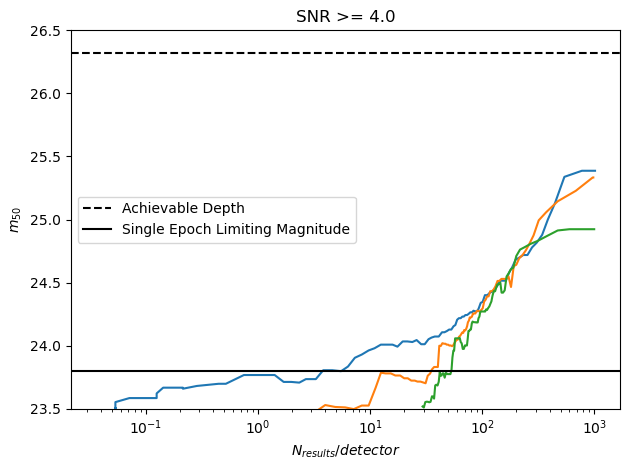

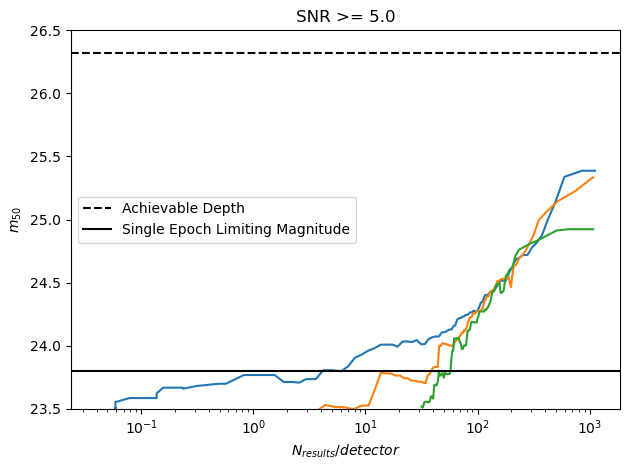

In [153]:
plt.figure()
_x = []
_y = []
_y_err = []
t = 'tno'

n = 2e2
for snr in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]:
#     for dx in 
    for dx in [3, 5, 10]:
        j = joined['tno'][dx]
        j = j[j['snr'] == snr]
        if len(j) == 0:
            continue

        n_detectors = len(set(j['detector']))
        N_results = int(n) * n_detectors
    #     print(N_results)

        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][dx][3.0]
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        closest = np.argmin(np.abs(np.array(n_results) - N_results))
        fpr = n_fakes_found / N_results
        plt.plot((n_results - n_fakes_found) / n_detectors, m_50)
    #     _x.append(dx)
    #     _y.append(m_50[closest])
    #     _y_err.append(m_50_err[closest])

    #         plt.errorbar(_x, _y, yerr=_y_err, fmt='o', label={"tno": "TNO", "ast": "MBA"}.get(t))
    # plt.scatter(_x, _y, label={"tno": "TNO", "ast": "MBA"}.get(t))
    __x = np.linspace(0, 5, 100)
    __y = mag_ref - 5/2*np.log10(np.array(__x)/5)
    # plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
    plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
    plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
    # plt.scatter(_x, _y)
    plt.ylim(23.5, 26.5)
    plt.legend()
    #     plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel("$N_{results} / detector$")
    plt.title(f"SNR >= {snr}")
    plt.ylabel("$m_{50}$")
    plt.xscale("log")
    # plt.title("$N_{results}/detector = $" + str(N_results/n_detectors))
    plt.legend()
    plt.tight_layout()
    #     plt.savefig(f"figures/m50_Nresults_{n}.pdf")
    #     plt.savefig(f"figures/m50_Nresults_{n}.png")
    plt.show()

In [ ]:
# the two key figures are m_50 vs N_{results}/detector and m_50 vs speedup
# speedup is related to \delta_x
# 

In [27]:
for n in [1e2, 2e2, 3e2]:
    plt.figure()
    for t in roc_lookup:
        _x = []
        _y = []
        _y_err = []
        
        for dx in roc_lookup[t]:
            for snr in roc_lookup[t][dx]:
                
            j = joined[t]
#             if t == "ast":
#                 j = joined_ast
#             else:
#                 j = joined_tno
            n_detectors = len(set(j[dx]['detector']))
            N_results = int(n) * n_detectors
            
            x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
            m_50 = np.array([f['m_50'] for f in fit_results])
            m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
            closest = np.argmin(np.abs(np.array(n_results) - N_results))
            fpr = n_fakes_found / N_results
            _x.append(snr)
            _y.append(m_50[closest])
            _y_err.append(m_50_err[closest])

#         plt.errorbar(_x, _y, yerr=_y_err, fmt='o', label={"tno": "TNO", "ast": "MBA"}.get(t))
        plt.scatter(_x, _y, label={"tno": "TNO", "ast": "MBA"}.get(t))
    __x = np.linspace(0, 5, 100)
    __y = mag_ref - 5/2*np.log10(np.array(__x)/5)
    plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
    plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
    plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
    # plt.scatter(_x, _y)
    plt.ylim(23.5, 26.5)
    plt.legend()
#     plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel("SNR")
    plt.ylabel("$m_{50}$")
    plt.title("$N_{results}/detector = $" + str(N_results/n_detectors))
    plt.legend()
    plt.tight_layout()
#     plt.savefig(f"figures/m50_Nresults_{n}.pdf")
#     plt.savefig(f"figures/m50_Nresults_{n}.png")
    plt.show()

ValueError: not enough values to unpack (expected 5, got 3)

<Figure size 640x480 with 0 Axes>

In [ ]:
# accuracy: n_fakes_found/n_fakes
# purity = n_fakes_found/n_results

In [104]:
m = np.arange(22, 27)
plt.cm.Blues(m)

array([[0.90096117, 0.9410073 , 0.97834679, 1.        ],
       [0.89788543, 0.93903883, 0.97736255, 1.        ],
       [0.89480969, 0.93707036, 0.97637832, 1.        ],
       [0.89173395, 0.93510188, 0.97539408, 1.        ],
       [0.88865821, 0.93313341, 0.97440984, 1.        ]])

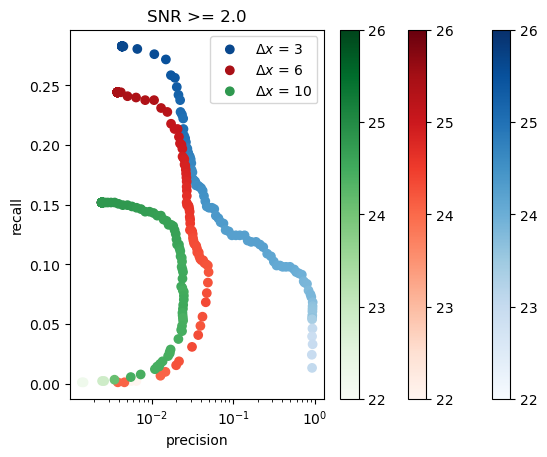

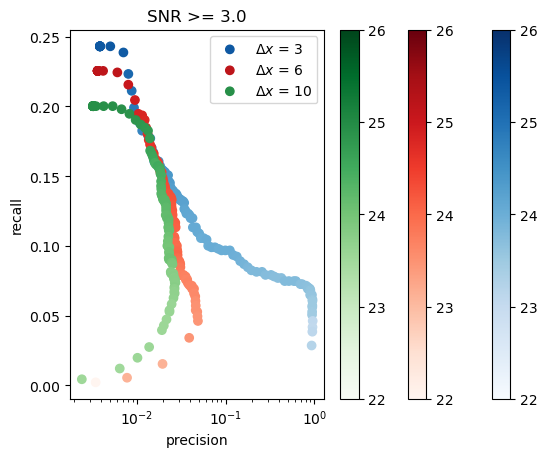

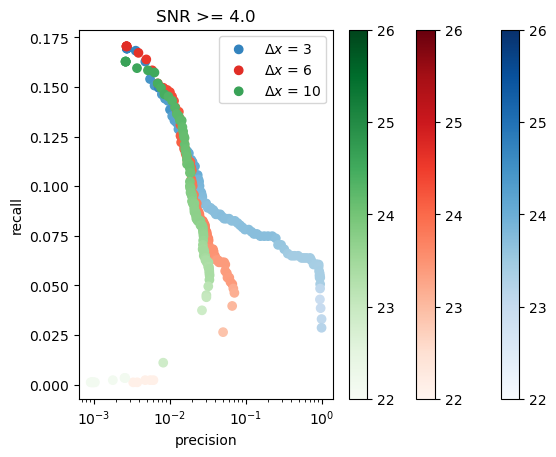

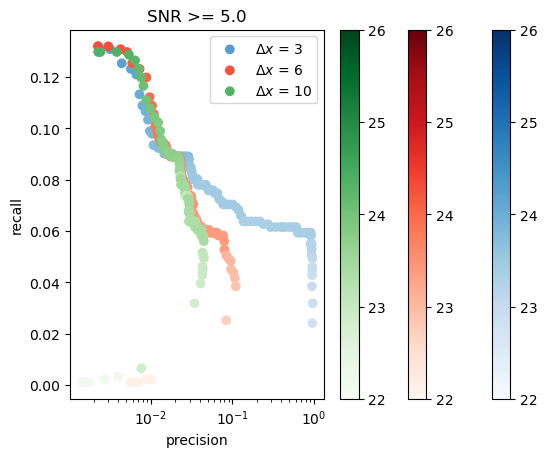

In [132]:


for snr in [2.0, 3.0, 4.0, 5.0]:
    for i, dx in enumerate([3, 6, 10]):
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][dx][snr]
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
#         plt.plot(m_50, n_fakes_found/n_fakes)
        precision = n_fakes_found/n_results
        recall = n_fakes_found/n_fakes
        recall = n_fakes_found/909
        plt.scatter(precision, recall, c=m_50, cmap={0: 'Blues', 1: 'Reds', 2: 'Greens'}.get(i), label="$\Delta x$ = " + str(dx))
#         plt.plot(precision, m_50, label="$\Delta x$ = " + str(dx))
        cbar = plt.colorbar(ticks=np.arange(22, 27))
#         print(cbar)
        plt.clim(22, 26)
    plt.xscale("log")
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.legend()
    plt.title(f"SNR >= {snr}")
    plt.show()


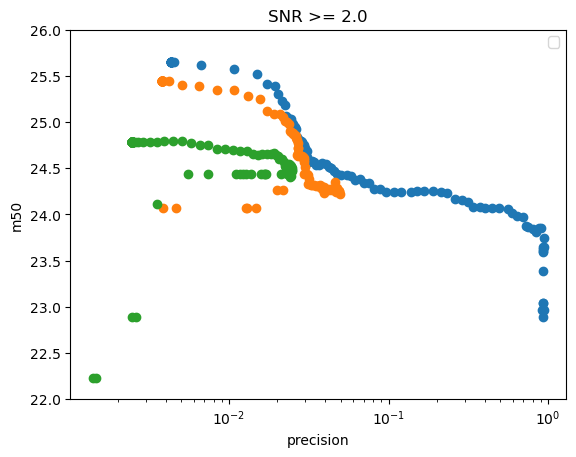

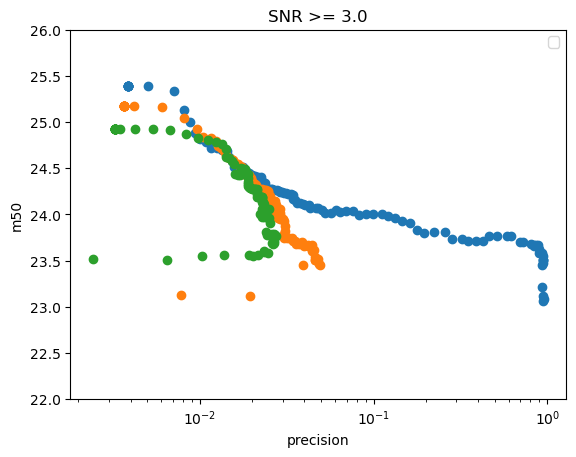

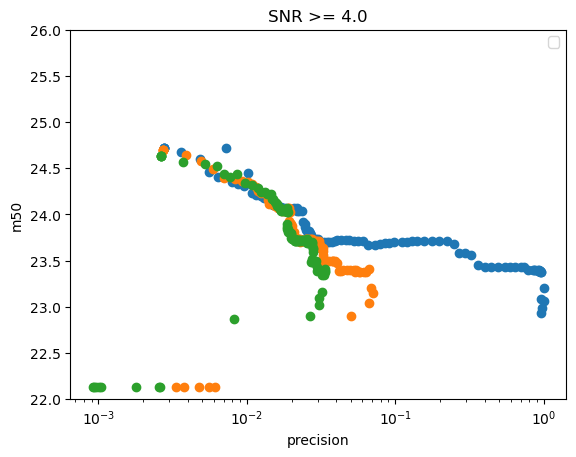

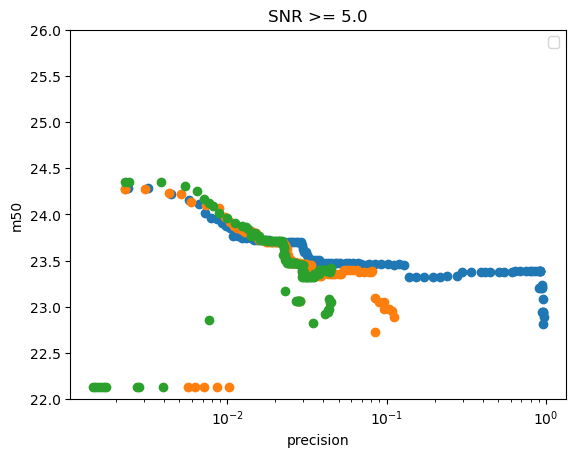

In [138]:


for snr in [2.0, 3.0, 4.0, 5.0]:
    for i, dx in enumerate([3, 6, 10]):
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup['tno'][dx][snr]
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
#         plt.plot(m_50, n_fakes_found/n_fakes)
        precision = n_fakes_found/n_results
        recall = n_fakes_found/n_fakes
        recall = n_fakes_found/909
        plt.scatter(precision, m_50)#, c=recall, cmap={0: 'Blues', 1: 'Reds', 2: 'Greens'}.get(i), label="$\Delta x$ = " + str(dx))
#         plt.plot(precision, m_50, label="$\Delta x$ = " + str(dx))
#         cbar = plt.colorbar(ticks=np.arange(22, 27))
#         print(cbar)
#         plt.clim(0, 1)
    plt.ylim(22, 26)
    plt.xscale("log")
    plt.xlabel("precision")
    plt.ylabel("m50")
    plt.legend()
    plt.title(f"SNR >= {snr}")
    plt.show()
